# TAL Research
## **Modelling: Part 1 of 4** - Feature Selection and Modelling, Intersection Data



**Objective**: Develop a small scale model based on the data provided to appropriately help the team prioritize accounts for our sales reps to target.

**What we know**:
- **unique ID** is the id_number, i.e. every id number belongs to a unique company. This is important because it determines how we will consider (concatenate) the different datasets (excel files) with each other.

**Datasets**:
- **Train**: 254 accounts that have been reached out to, with 122 successful sales
- **Test**: 132 target accounts, which have had **no** interacitons yet




## Imports

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [145]:
import chart_studio
chart_studio.tools.set_credentials_file(username='thevitorialima', api_key='Z0P9d5apmfWIA3UYmS5G')


In [146]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


In [147]:
import pandas as pd

# Define the paths to the imputed datasets
train_data_path = '../../../data_processed/intersection/train.csv'
test_data_path = '../../../data_processed/intersection/test.csv'

# Load the imputed datasets
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train.set_index('id_number', inplace=True)
test.set_index('id_number', inplace=True)

# Display the first few rows to verify the data
print("Train Data Imputed:")
print(train.shape)
print(train['target_met'].sum())

print("Test Data Imputed:")
print(test.shape)


Train Data Imputed:
(254, 105)
122
Test Data Imputed:
(132, 104)


### Loading data, creating one hot encoded variables for categorical variables

In [148]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


# Define the categories to check for the condition
categories = ['org_size_1_99', 'org_size_500_999', 'org_size_1000_4999', 'org_size_greaterthan_5000']

# Condition to filter data where all categories are 0
condition_train = (train[categories] == 0).all(axis=1)
condition_test = (test[categories] == 0).all(axis=1)

# Set the 'org_size_100_499' column to 1 where the condition is met
train.loc[condition_train, 'org_size_100_499'] = 1
test.loc[condition_test, 'org_size_100_499'] = 1

# Define the date columns
date_cols = ['first_engagement_date', 'last_engagement_date', 'first_action_date', 'last_action_date', 'first_intent_date', 'last_intent_date']

# Extract month from the date columns
for col in date_cols:
    train[col] = pd.to_datetime(train[col])
    train[f"{col}_month"] = train[col].dt.month

    test[col] = pd.to_datetime(test[col])
    test[f"{col}_month"] = test[col].dt.month

# Drop the original date columns
train = train.drop(columns=date_cols)
test = test.drop(columns=date_cols)

# Define features and target
X_train = train.drop(columns=['target_met'])
y_train = train['target_met']

X_test = test
# y_test = test['target_met']

# Define categorical and numerical columns
categorical_cols = ['Industry', 'billingstatecode', 'D&B_Score']
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-hot encode categorical variables for train
onehotencoder = OneHotEncoder(sparse_output=False)
X_train_encoded = pd.DataFrame(onehotencoder.fit_transform(X_train[categorical_cols]), index=X_train.index)
X_train_encoded.columns = onehotencoder.get_feature_names_out(categorical_cols)

# One-hot encode categorical variables for test
X_test_encoded = pd.DataFrame(onehotencoder.transform(X_test[categorical_cols]), index=X_test.index)
X_test_encoded.columns = onehotencoder.get_feature_names_out(categorical_cols)

# Drop original categorical columns and add one-hot encoded columns for train
X_train = X_train.drop(columns=categorical_cols)
X_train = pd.concat([X_train, X_train_encoded], axis=1)

# Drop original categorical columns and add one-hot encoded columns for test
X_test = X_test.drop(columns=categorical_cols)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Print the final DataFrames to verify
print("\nTrain DataFrame after preprocessing:")
print(X_train.head())
print(X_train.shape)

print("\nTest DataFrame after preprocessing:")
print(X_test.head())
print(X_test.shape)

# Verify 'id_number' is still the index
print("\nTrain index name:")
print(X_train.index.name)

print("\nTest index name:")
print(X_test.index.name)

# Ensure the shapes are correct
assert X_train.shape[0] == 254, "Train dataset row count changed!"
assert X_test.shape[0] == test.shape[0], "Test dataset row count changed!"



Train DataFrame after preprocessing:
           org_size_1_99  org_size_100_499  org_size_500_999  \
id_number                                                      
76                     0                 1                 0   
120                    0                 0                 1   
127                    1                 0                 0   
156                    0                 1                 0   
188                    1                 0                 0   

           org_size_1000_4999  org_size_greaterthan_5000  Has_Website  \
id_number                                                               
76                          0                          0            1   
120                         0                          0            1   
127                         0                          0            1   
156                         0                          0            1   
188                         0                          0            0   

 

In [149]:
X_train

,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Has_Website,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,...,billingstatecode_TX,billingstatecode_UT,billingstatecode_VA,billingstatecode_WA,billingstatecode_WI,billingstatecode_WV,billingstatecode_WY,D&B_Score_HIGH,D&B_Score_LOW,D&B_Score_MEDIUM
id_number,,,,,,,,,,,,,,,,,,,,,
76,0,1,0,0,0,1,17.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
120,0,0,1,0,0,1,50.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
127,1,0,0,0,0,1,50.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
156,0,1,0,0,0,1,2200.0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
188,1,0,0,0,0,0,23.0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,0,1,0,0,0,1,2.0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2732,1,0,0,0,0,0,20.0,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2773,1,0,0,0,0,1,60.0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Feature Selection with Random Forest and additive Logistic Regression

In [150]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from datetime import datetime
import chart_studio
import chart_studio.plotly as py

# Set Chart Studio credentials
chart_studio.tools.set_credentials_file(username='thevitorialima', api_key='Z0P9d5apmfWIA3UYmS5G')

# Function to streamline the process for the entire dataset
def model_for_entire_dataset(X, y, num_features, threshold=0.5):
    results = {}
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train RandomForestClassifier
    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    
    # Calculate AUC score on validation set
    rf_auc_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    
    # Get feature importances
    feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    # Initialize lists
    base_clf_list = []
    train_auc_list = []
    test_auc_list = []
    confusion_matrices = []
    precisions = []
    recalls = []
    f1_scores = []
    roc_curves = []
    
    for i in range(num_features):  # Limiting to the first num_features most important features
        feature_names = list(feature_importances_sorted.index[:i+1])
        
        base_clf = LogisticRegression(random_state=0, solver='newton-cg', penalty='l2', C=1.0)
        base_clf.fit(X_train[feature_names], y_train)
        
        # Calculate AUC scores
        train_auc = roc_auc_score(y_train, base_clf.predict_proba(X_train[feature_names])[:, 1])
        val_auc = roc_auc_score(y_val, base_clf.predict_proba(X_val[feature_names])[:, 1])
        
        base_clf_list.append(base_clf)
        train_auc_list.append(train_auc)
        test_auc_list.append(val_auc)

        # Calculate predictions with custom threshold
        y_val_proba = base_clf.predict_proba(X_val[feature_names])[:, 1]
        y_val_pred = (y_val_proba >= threshold).astype(int)
        
        # Calculate confusion matrix, precision, recall, and f1 score
        cm = confusion_matrix(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)
        
        confusion_matrices.append(cm)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        roc_curves.append((fpr, tpr))
    
    # Print coefficient interpretations
    print(f"Interpreting coefficients for model with top {num_features} features:")
    coef = base_clf_list[-1].coef_[0]
    for j, feature in enumerate(feature_names):
        log_odds = coef[j]
        odds = np.exp(log_odds)
        probability = odds / (1 + odds)
        print(f"Feature: {feature}")
        print(f"  Log Odds: {log_odds:.4f}")
        print(f"  Odds: {odds:.4f}")
        print(f"  Probability: {probability*100:.2f}%")
        print(f"  Interpretation: For a one-unit increase in {feature}, the odds of the positive outcome {'increase' if log_odds > 0 else 'decrease'} by {odds:.4f} times (or by {(odds-1)*100:.2f}%). This corresponds to an increase in the probability to {probability*100:.2f}%.")

    # Store results
    results['feature_importances_sorted'] = feature_importances_sorted
    results['base_clf_list'] = base_clf_list
    results['train_auc_list'] = train_auc_list
    results['test_auc_list'] = test_auc_list
    results['rf_auc_val'] = rf_auc_val
    results['confusion_matrices'] = confusion_matrices
    results['precisions'] = precisions
    results['recalls'] = recalls
    results['f1_scores'] = f1_scores
    results['roc_curves'] = roc_curves
    
    return results

def plot_results(X, y, num_features, threshold=0.5):
    # Train models and get results
    results = model_for_entire_dataset(X, y, num_features, threshold)
    
    # Plotting the results using Plotly
    def plot_auc_scores(results, num_features):
        x_axis = list(range(1, num_features+1))
        fig_auc = go.Figure()

        fig_auc.add_trace(go.Scatter(x=x_axis, y=results['train_auc_list'], mode='lines+markers', name='Train AUC'))
        fig_auc.add_trace(go.Scatter(x=x_axis, y=results['test_auc_list'], mode='lines+markers', name='Test AUC'))
        fig_auc.add_trace(go.Scatter(x=x_axis, y=[results['rf_auc_val']] * num_features, mode='lines', name='RF AUC', line=dict(dash='dash')))

        fig_auc.update_layout(
            title=f'AUC Scores for Top {num_features} Features',
            xaxis_title='Number of Variables',
            yaxis_title='AUC',
            legend_title='Legend'
        )
        return fig_auc

    def plot_lr_coefficients(results, num_features):
        coef = results['base_clf_list'][num_features-1].coef_[0]
        fig_coef = go.Figure()
        fig_coef.add_trace(go.Bar(x=list(results['feature_importances_sorted'].index[:num_features]), y=coef))

        fig_coef.update_layout(
            title=f'LR Coefficients for Top {num_features} Features',
            xaxis_title='Feature',
            yaxis_title='Coefficient (Log Odds)',
            xaxis_tickangle=45
        )
        return fig_coef

    fig_auc = plot_auc_scores(results, num_features)
    fig_coef = plot_lr_coefficients(results, num_features)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    auc_filename = f'auc_scores_{timestamp}.html'
    coef_filename = f'lr_coefficients_{timestamp}.html'
    
    py.plot(fig_auc, filename=auc_filename, auto_open=False)
    py.plot(fig_coef, filename=coef_filename, auto_open=False)
    
    print(f'AUC plot saved to: {auc_filename}')
    print(f'LR coefficients plot saved to: {coef_filename}')
    
    # Show plots locally
    fig_auc.show()
    fig_coef.show()
    
    # Plotting confusion matrix and ROC curve using matplotlib and seaborn
    def plot_confusion_matrix_and_roc(results):
        cm = results['confusion_matrices'][num_features-1]
        fpr, tpr = results['roc_curves'][num_features-1]
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        sns.heatmap(cm, annot=True, fmt="d", ax=axes[0])
        axes[0].set_title(f'Confusion Matrix for Top {num_features} Features')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('True Label')
        
        axes[1].plot(fpr, tpr, label=f'AUC: {results["test_auc_list"][num_features-1]:.4f}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title(f'ROC Curve for Top {num_features} Features')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='best')
        
        plt.tight_layout()
        plt.show()
    
    plot_confusion_matrix_and_roc(results)

# Example usage
# Assuming X and y are defined, you can call the plot_results function
# plot_results(X, y, num_features=10, threshold=0.5)


Interpreting coefficients for model with top 4 features:
Feature: total_actions
  Log Odds: -0.0575
  Odds: 0.9441
  Probability: 48.56%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9441 times (or by -5.59%). This corresponds to an increase in the probability to 48.56%.
Feature: reply_count
  Log Odds: 0.1162
  Odds: 1.1232
  Probability: 52.90%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1232 times (or by 12.32%). This corresponds to an increase in the probability to 52.90%.
Feature: cumulative_reply_count
  Log Odds: 0.1503
  Odds: 1.1622
  Probability: 53.75%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.1622 times (or by 16.22%). This corresponds to an increase in the probability to 53.75%.
Feature: action_count_lag_2
  Log Odds: 1.1459
  Odds: 3.1452
  Probability: 75.88%
  Interpretation: F

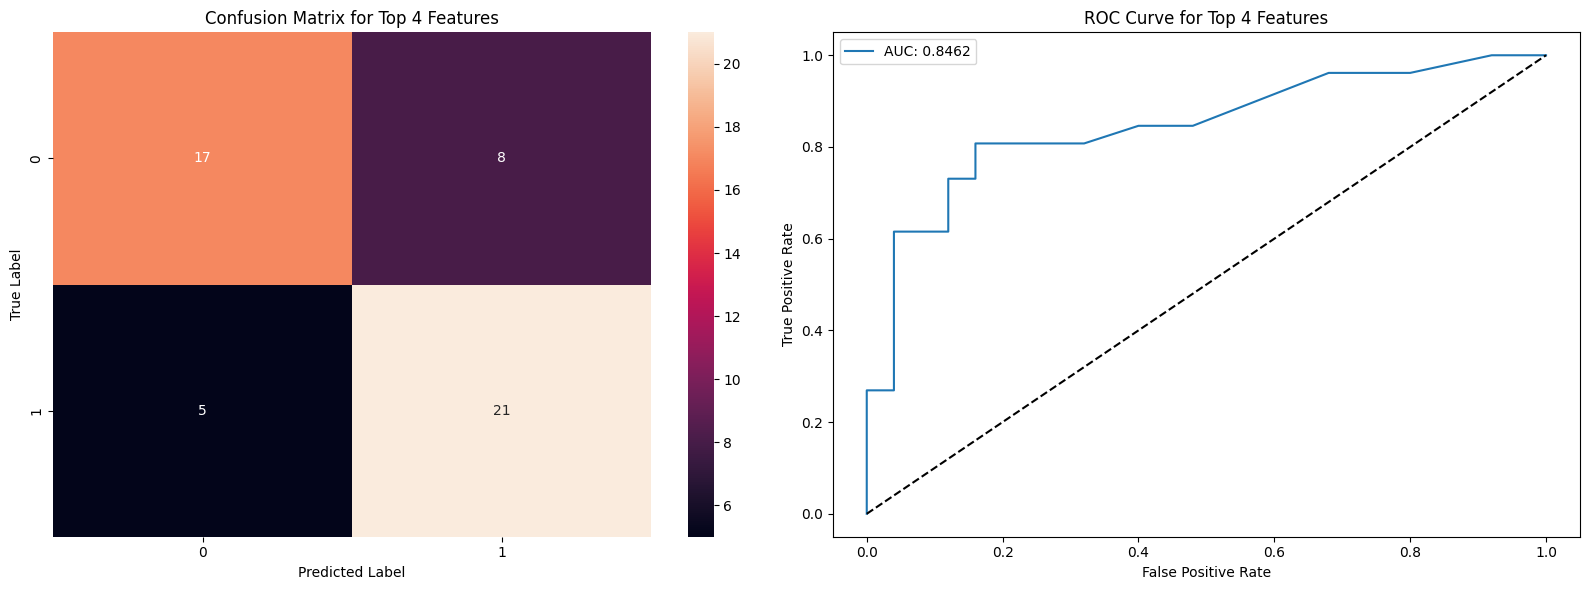

Interpreting coefficients for model with top 6 features:
Feature: total_actions
  Log Odds: -0.0475
  Odds: 0.9536
  Probability: 48.81%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9536 times (or by -4.64%). This corresponds to an increase in the probability to 48.81%.
Feature: reply_count
  Log Odds: 0.1181
  Odds: 1.1254
  Probability: 52.95%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1254 times (or by 12.54%). This corresponds to an increase in the probability to 52.95%.
Feature: cumulative_reply_count
  Log Odds: 0.1434
  Odds: 1.1542
  Probability: 53.58%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.1542 times (or by 15.42%). This corresponds to an increase in the probability to 53.58%.
Feature: action_count_lag_2
  Log Odds: 1.1009
  Odds: 3.0068
  Probability: 75.04%
  Interpretation: F

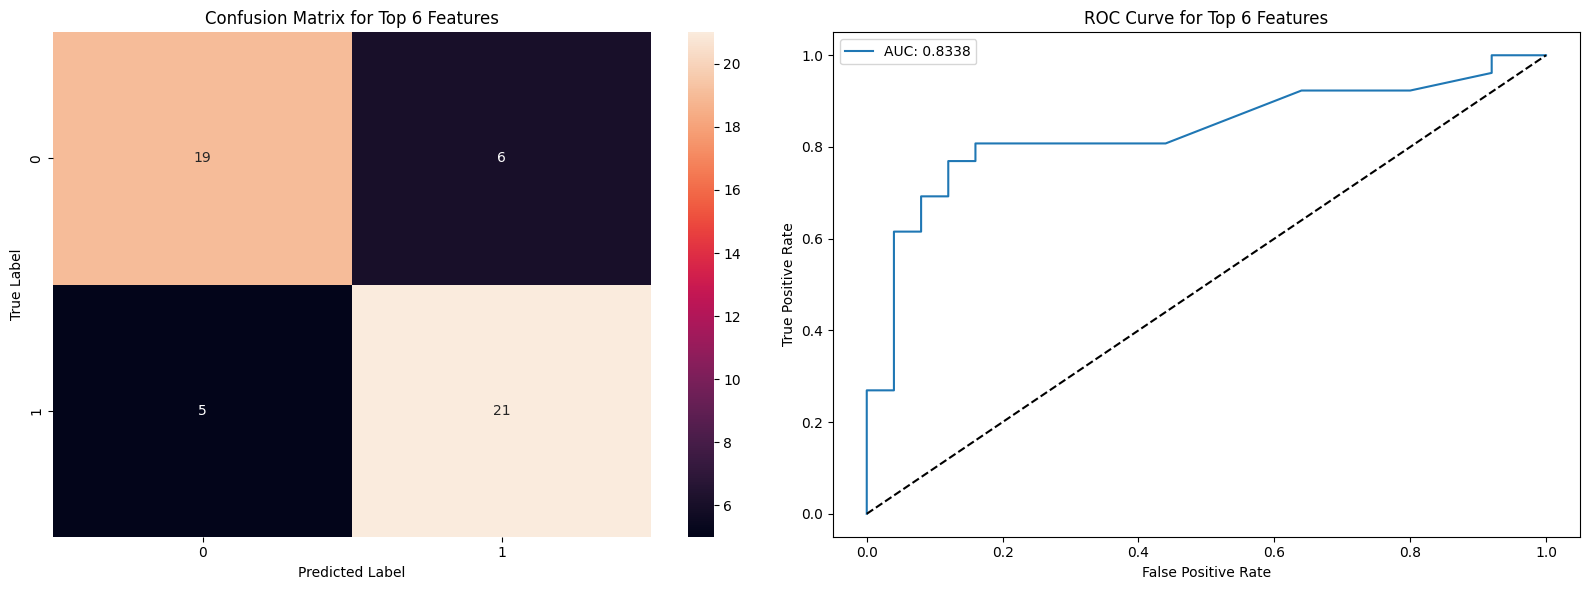

Interpreting coefficients for model with top 10 features:
Feature: total_actions
  Log Odds: -0.0120
  Odds: 0.9881
  Probability: 49.70%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9881 times (or by -1.19%). This corresponds to an increase in the probability to 49.70%.
Feature: reply_count
  Log Odds: 0.1106
  Odds: 1.1169
  Probability: 52.76%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1169 times (or by 11.69%). This corresponds to an increase in the probability to 52.76%.
Feature: cumulative_reply_count
  Log Odds: 0.0864
  Odds: 1.0902
  Probability: 52.16%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.0902 times (or by 9.02%). This corresponds to an increase in the probability to 52.16%.
Feature: action_count_lag_2
  Log Odds: 1.1102
  Odds: 3.0349
  Probability: 75.22%
  Interpretation: F

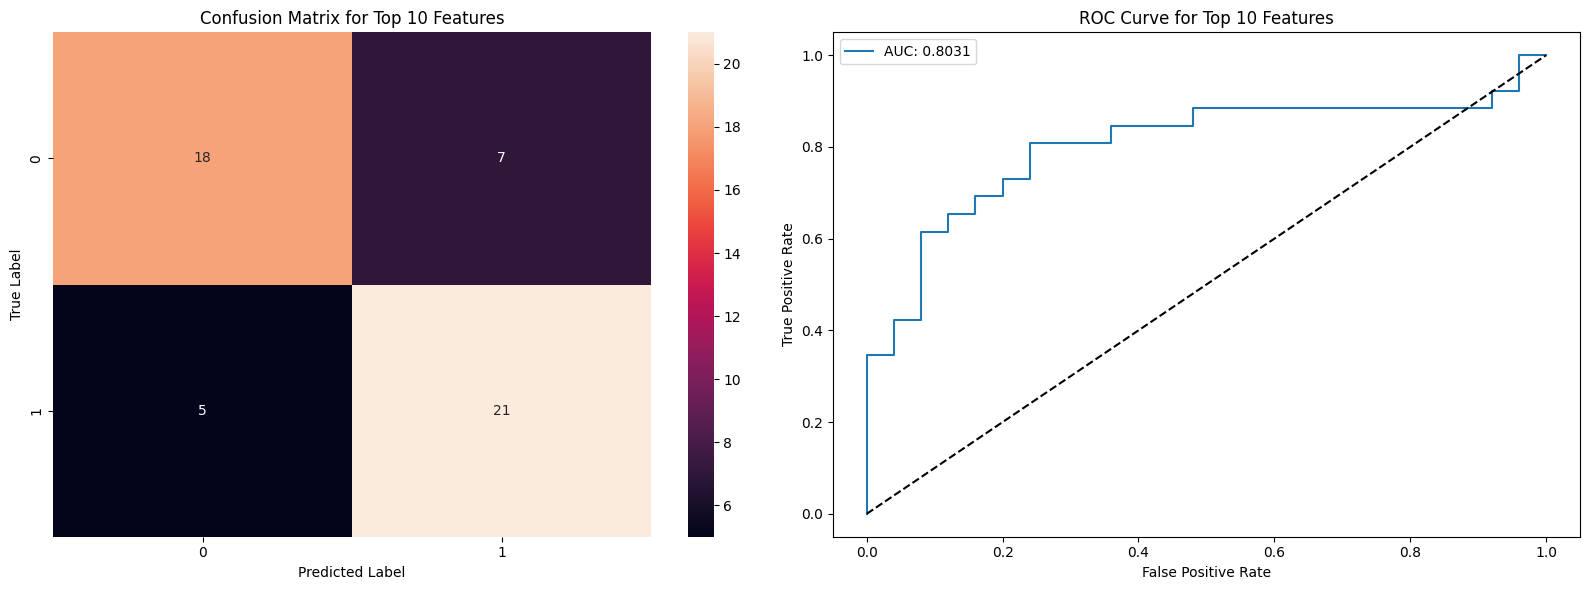

Interpreting coefficients for model with top 15 features:
Feature: total_actions
  Log Odds: -0.0089
  Odds: 0.9912
  Probability: 49.78%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9912 times (or by -0.88%). This corresponds to an increase in the probability to 49.78%.
Feature: reply_count
  Log Odds: 0.0915
  Odds: 1.0958
  Probability: 52.29%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.0958 times (or by 9.58%). This corresponds to an increase in the probability to 52.29%.
Feature: cumulative_reply_count
  Log Odds: 0.1032
  Odds: 1.1087
  Probability: 52.58%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.1087 times (or by 10.87%). This corresponds to an increase in the probability to 52.58%.
Feature: action_count_lag_2
  Log Odds: 0.3776
  Odds: 1.4587
  Probability: 59.33%
  Interpretation: F

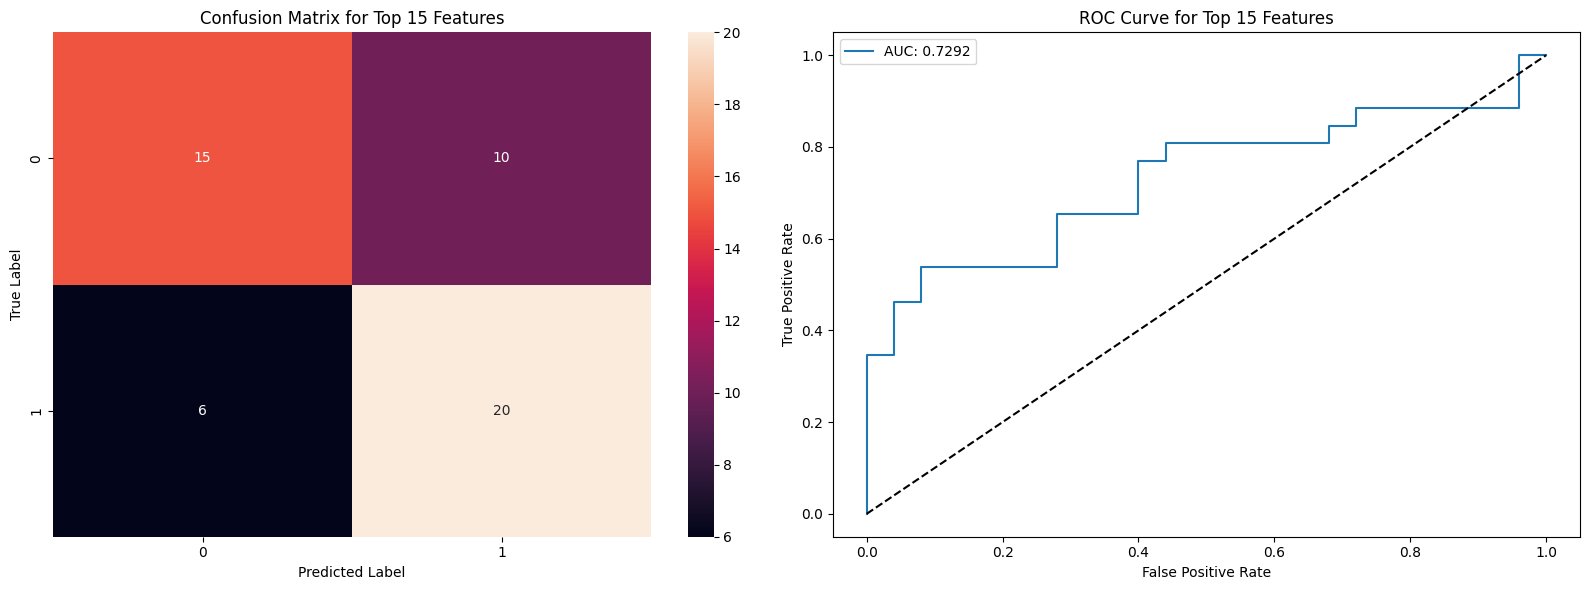

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311

Interpreting coefficients for model with top 171 features:
Feature: total_actions
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: reply_count
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: cumulative_reply_count
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: action_count_lag_2
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For

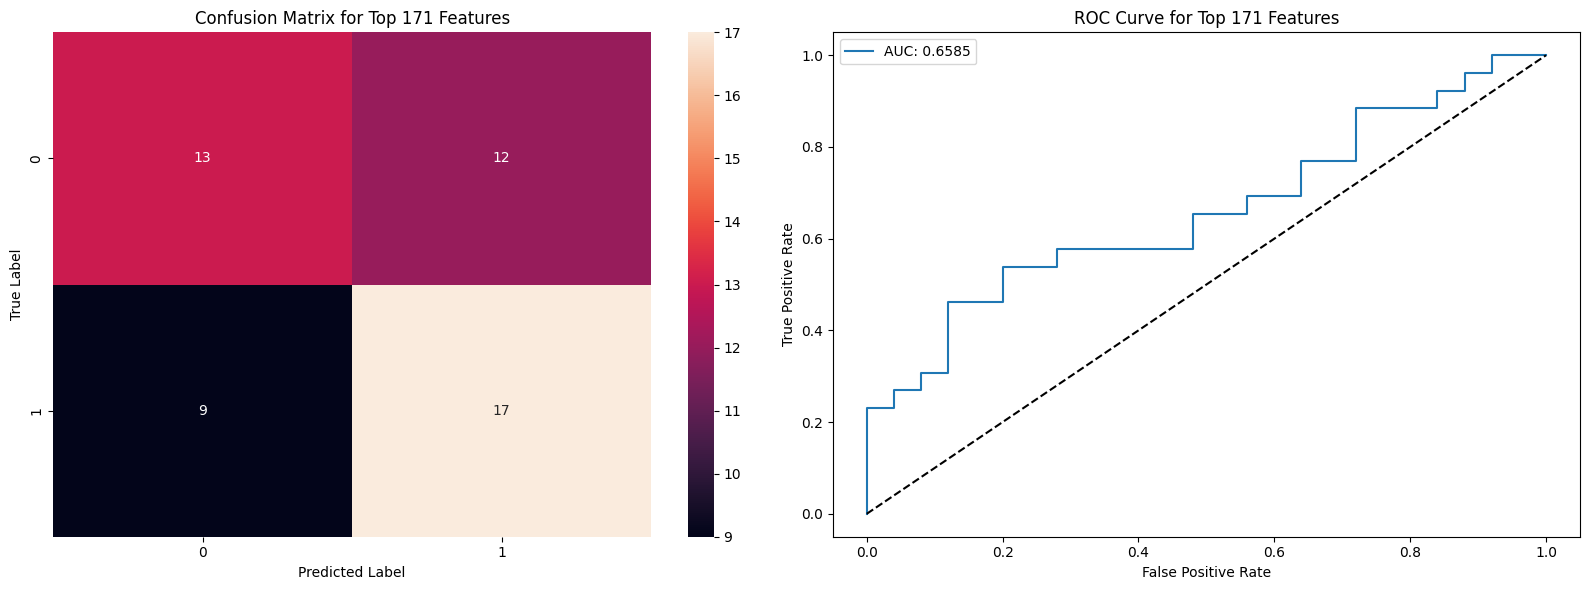

In [151]:
# Example usage
plot_results(X_train, y_train, 4 , threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, 6, threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, 10, threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, 15, threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, len(X_train.columns), threshold=0.45)  # Adjust threshold to reduce false negatives

### Feature Importance

In [152]:
import pandas as pd
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train and y_train are already loaded as DataFrames

# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=True)

# Create a bar plot for feature importances
fig = px.bar(
    feature_importances_sorted,
    x=feature_importances_sorted.values,
    y=feature_importances_sorted.index,
    orientation='h',
    labels={'x': 'Feature Importance', 'y': 'Features'},
    title='Feature Importances from RandomForestClassifier'
)

# Update layout
fig.update_layout(
    title_x=0.5,  # Center the title
    title_y=0.95,  # Adjust the title position if needed
    title_font_size=20  # Adjust the title font size if needed
)

# Show the plot
fig.show()


In [153]:
import pandas as pd
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
import chart_studio
import chart_studio.plotly as py

# Set Plotly credentials
chart_studio.tools.set_credentials_file(username='thevitorialima', api_key='Z0P9d5apmfWIA3UYmS5G')

# Assuming X_train and y_train are already loaded as DataFrames

# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=True)

# Select the top 20 features
top_20_features = feature_importances_sorted[-20:]

# Create a bar plot for the top 20 feature importances
fig = px.bar(
    top_20_features,
    x=top_20_features.values,
    y=top_20_features.index,
    orientation='h',
    labels={'x': 'Feature Importance', 'y': 'Features'},
    title='Top 20 Feature Importances from RandomForestClassifier'
)

# Update layout
fig.update_layout(
    title_x=0.5,  # Center the title
    title_y=0.95,  # Adjust the title position if needed
    title_font_size=20,  # Adjust the title font size if needed
    height=800  # Increase the height to accommodate all tickers
)

# Save to Plotly account
py.plot(fig, filename='top_20_feature_importances', auto_open=True)



'https://plotly.com/~thevitorialima/101/'

##### Same plots, but in seaborn

Interpreting coefficients for model with top 4 features:
Feature: total_actions
  Log Odds: -0.0575
  Odds: 0.9441
  Probability: 48.56%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9441 times (or by -5.59%). This corresponds to an increase in the probability to 48.56%.
Feature: reply_count
  Log Odds: 0.1162
  Odds: 1.1232
  Probability: 52.90%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1232 times (or by 12.32%). This corresponds to an increase in the probability to 52.90%.
Feature: cumulative_reply_count
  Log Odds: 0.1503
  Odds: 1.1622
  Probability: 53.75%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.1622 times (or by 16.22%). This corresponds to an increase in the probability to 53.75%.
Feature: action_count_lag_2
  Log Odds: 1.1459
  Odds: 3.1452
  Probability: 75.88%
  Interpretation: F

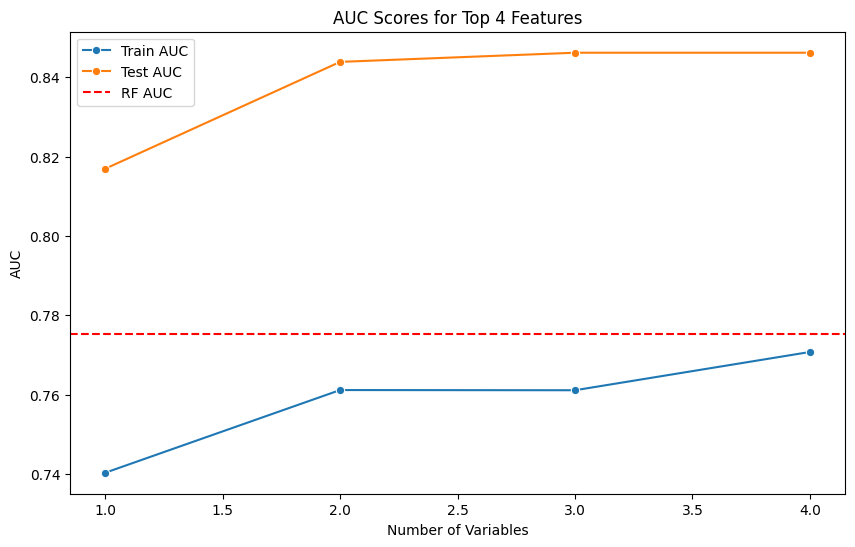

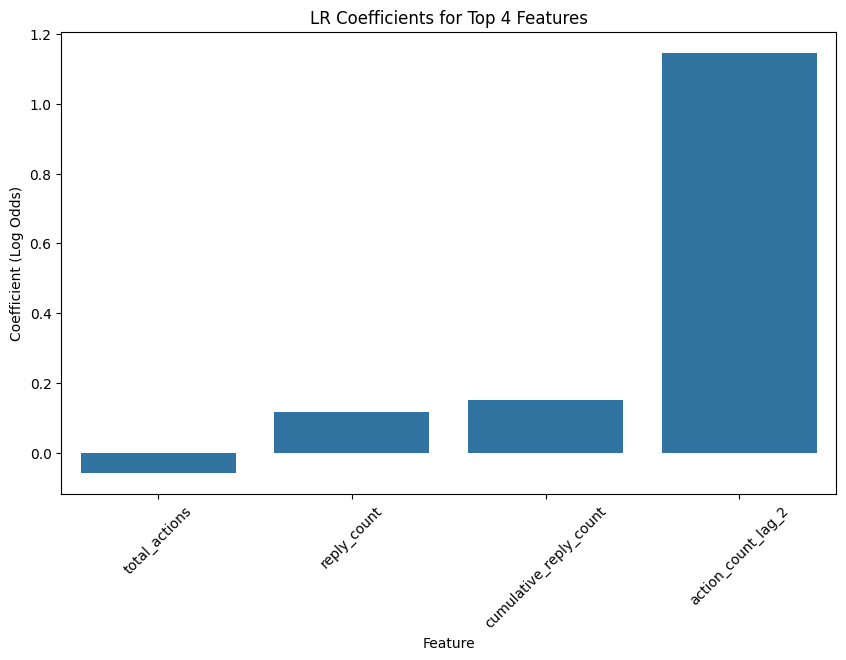

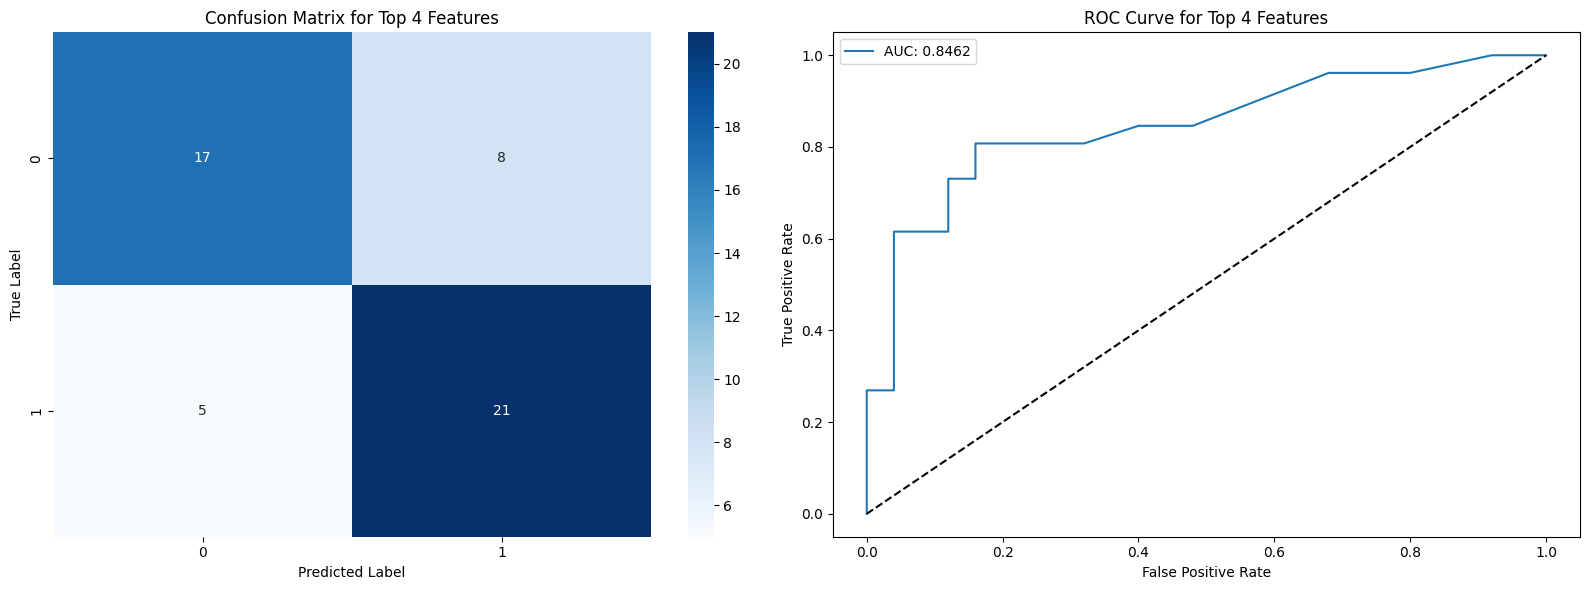

Interpreting coefficients for model with top 6 features:
Feature: total_actions
  Log Odds: -0.0475
  Odds: 0.9536
  Probability: 48.81%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9536 times (or by -4.64%). This corresponds to an increase in the probability to 48.81%.
Feature: reply_count
  Log Odds: 0.1181
  Odds: 1.1254
  Probability: 52.95%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1254 times (or by 12.54%). This corresponds to an increase in the probability to 52.95%.
Feature: cumulative_reply_count
  Log Odds: 0.1434
  Odds: 1.1542
  Probability: 53.58%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.1542 times (or by 15.42%). This corresponds to an increase in the probability to 53.58%.
Feature: action_count_lag_2
  Log Odds: 1.1009
  Odds: 3.0068
  Probability: 75.04%
  Interpretation: F

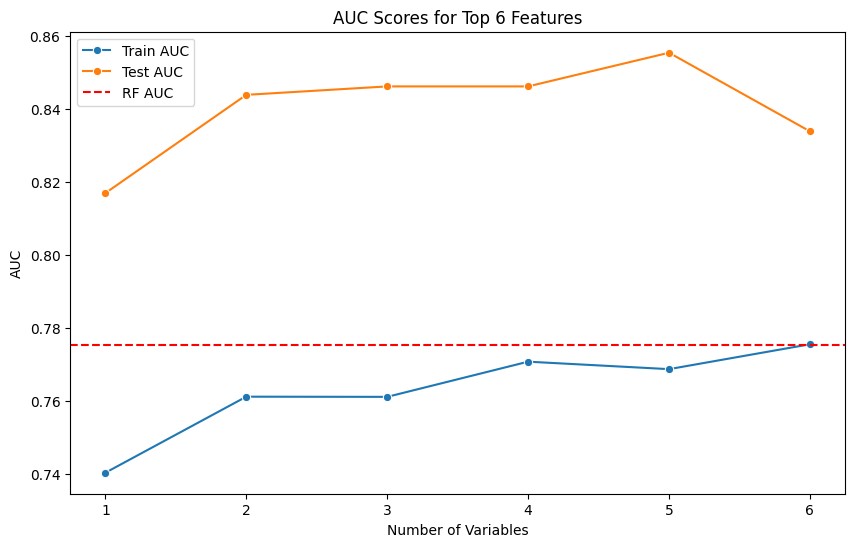

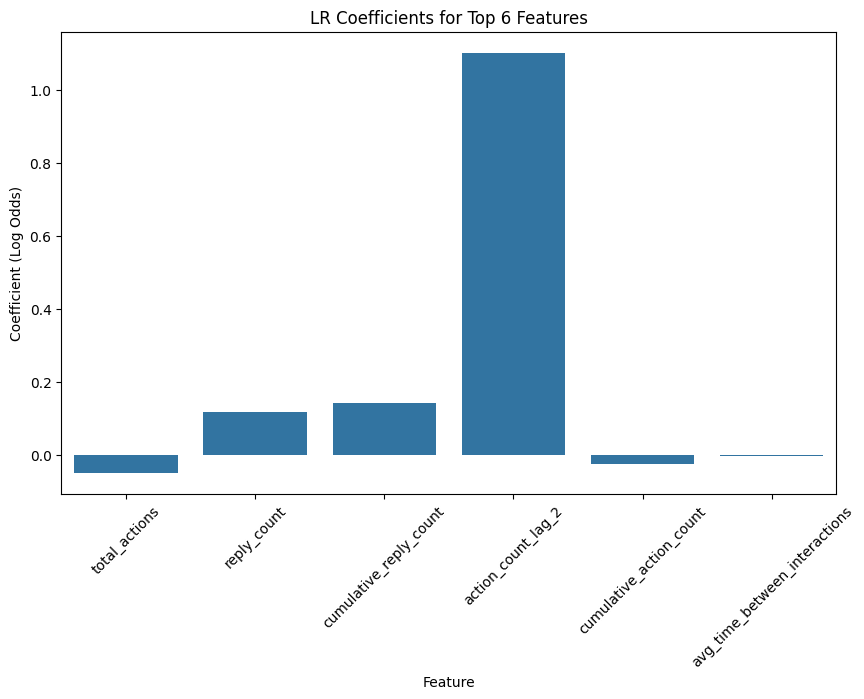

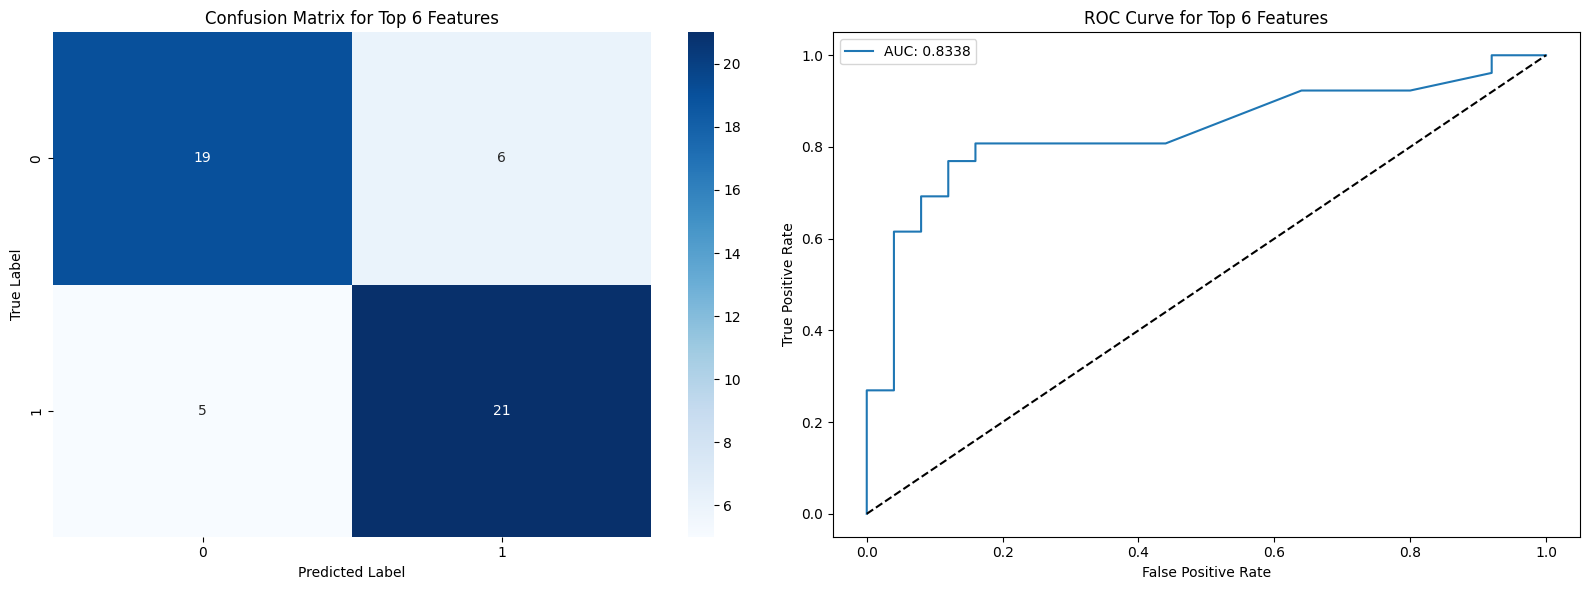

Interpreting coefficients for model with top 10 features:
Feature: total_actions
  Log Odds: -0.0120
  Odds: 0.9881
  Probability: 49.70%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9881 times (or by -1.19%). This corresponds to an increase in the probability to 49.70%.
Feature: reply_count
  Log Odds: 0.1106
  Odds: 1.1169
  Probability: 52.76%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1169 times (or by 11.69%). This corresponds to an increase in the probability to 52.76%.
Feature: cumulative_reply_count
  Log Odds: 0.0864
  Odds: 1.0902
  Probability: 52.16%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.0902 times (or by 9.02%). This corresponds to an increase in the probability to 52.16%.
Feature: action_count_lag_2
  Log Odds: 1.1102
  Odds: 3.0349
  Probability: 75.22%
  Interpretation: F

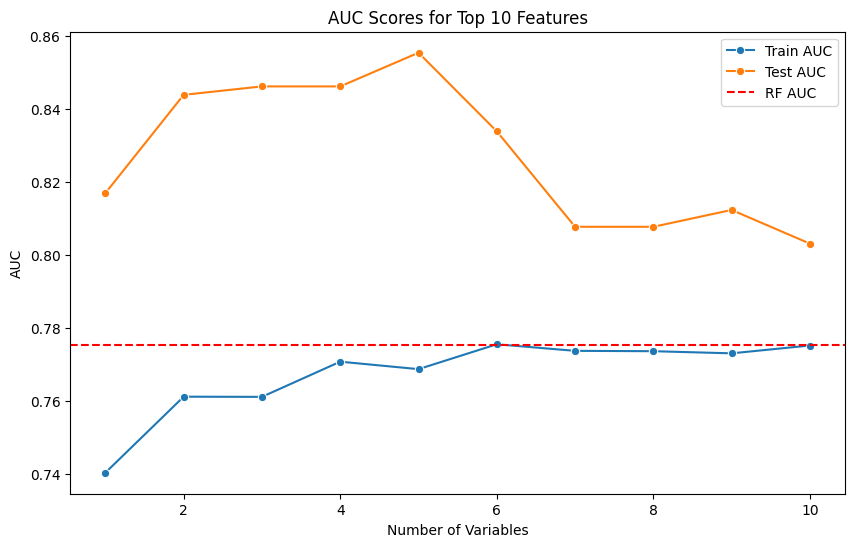

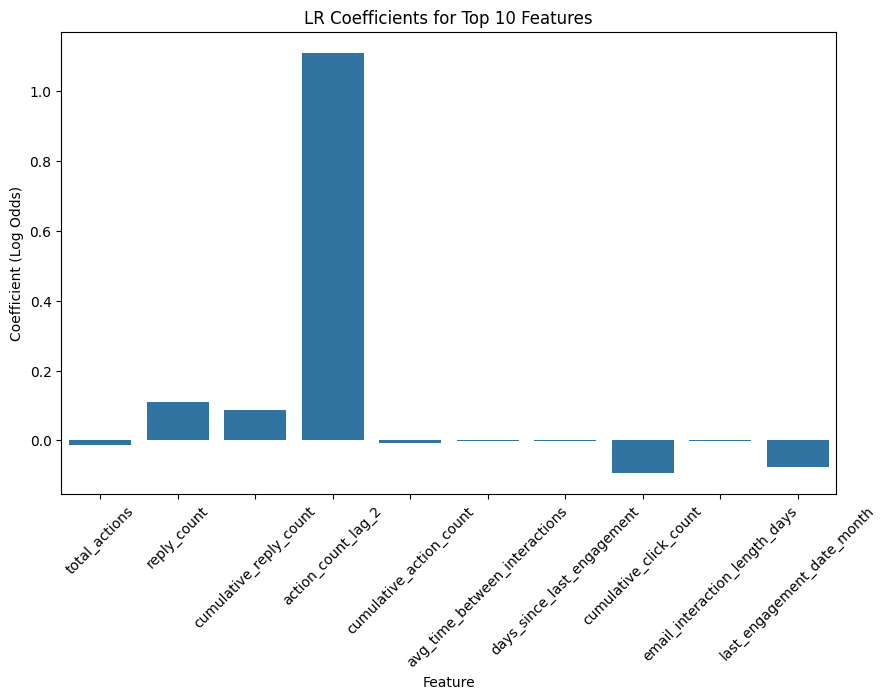

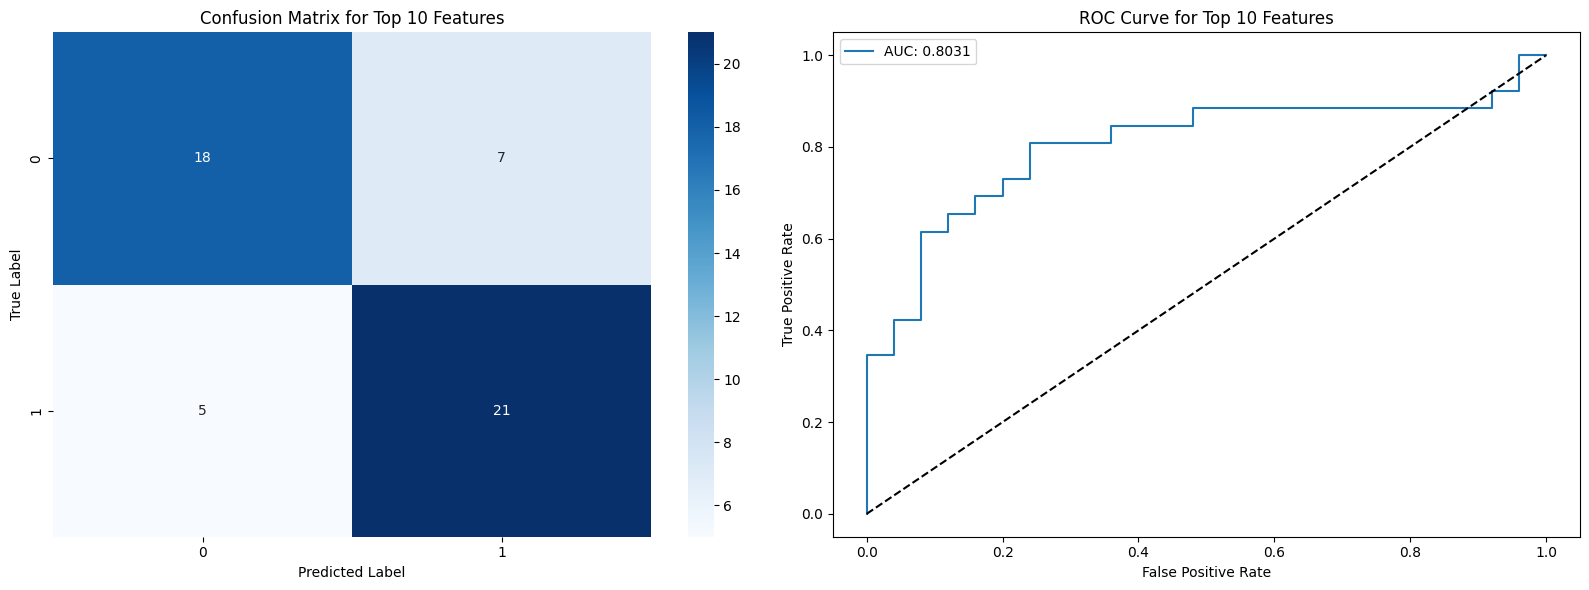

Interpreting coefficients for model with top 15 features:
Feature: total_actions
  Log Odds: -0.0089
  Odds: 0.9912
  Probability: 49.78%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9912 times (or by -0.88%). This corresponds to an increase in the probability to 49.78%.
Feature: reply_count
  Log Odds: 0.0915
  Odds: 1.0958
  Probability: 52.29%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.0958 times (or by 9.58%). This corresponds to an increase in the probability to 52.29%.
Feature: cumulative_reply_count
  Log Odds: 0.1032
  Odds: 1.1087
  Probability: 52.58%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.1087 times (or by 10.87%). This corresponds to an increase in the probability to 52.58%.
Feature: action_count_lag_2
  Log Odds: 0.3776
  Odds: 1.4587
  Probability: 59.33%
  Interpretation: F

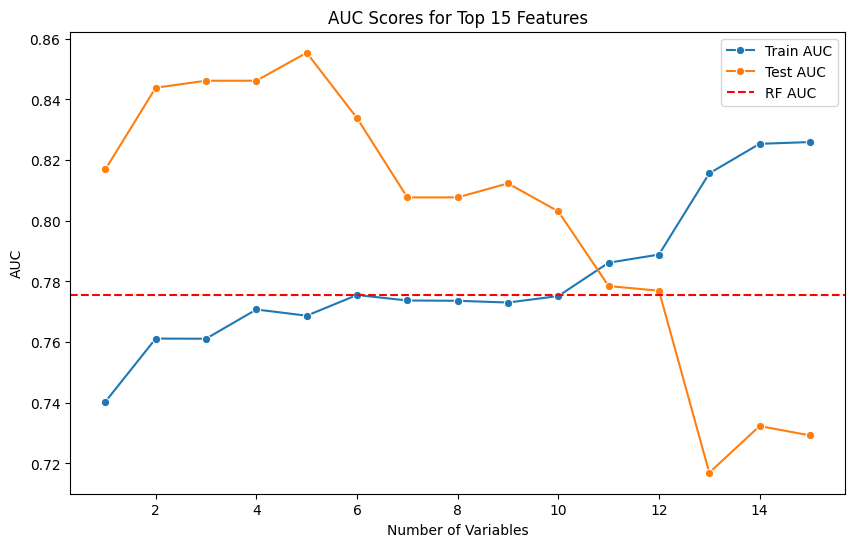

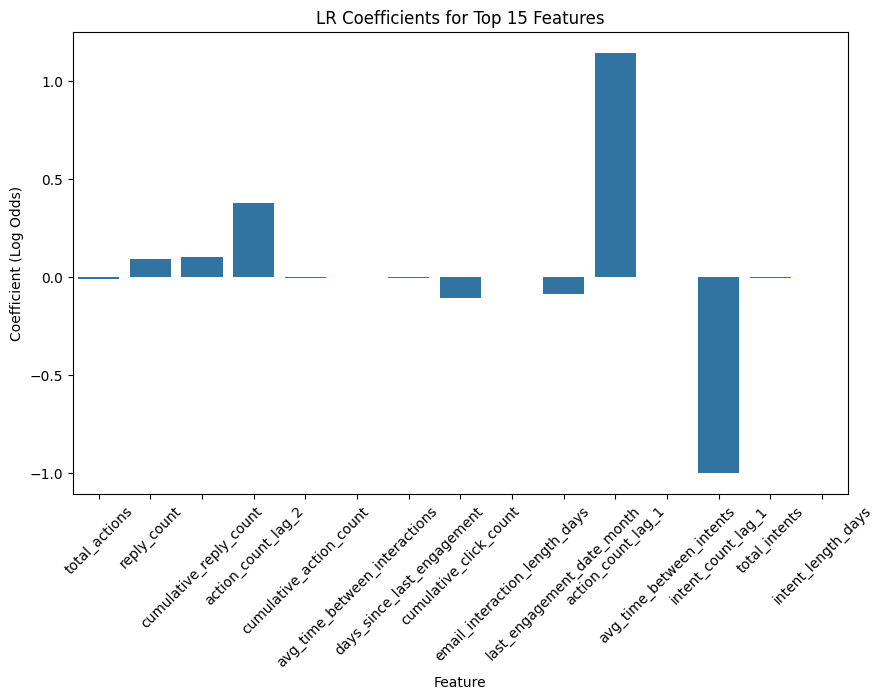

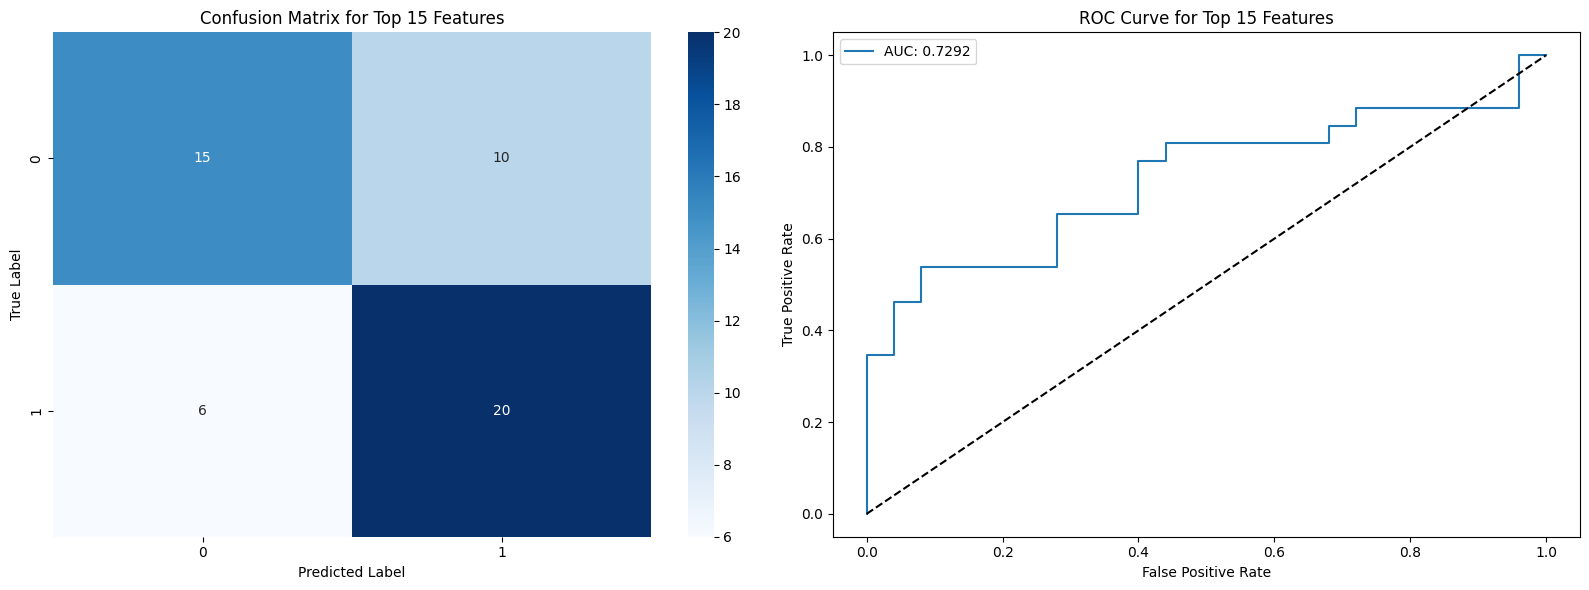

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311

Interpreting coefficients for model with top 171 features:
Feature: total_actions
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: reply_count
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: cumulative_reply_count
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: action_count_lag_2
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For

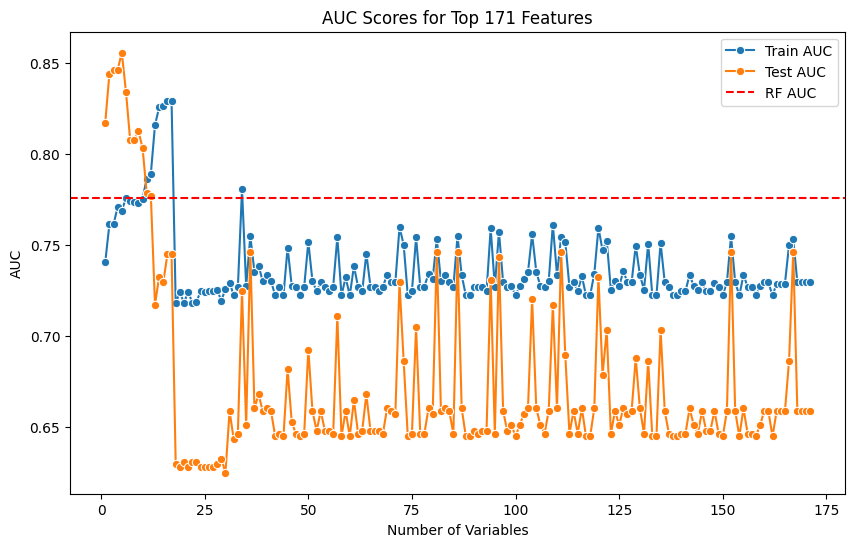

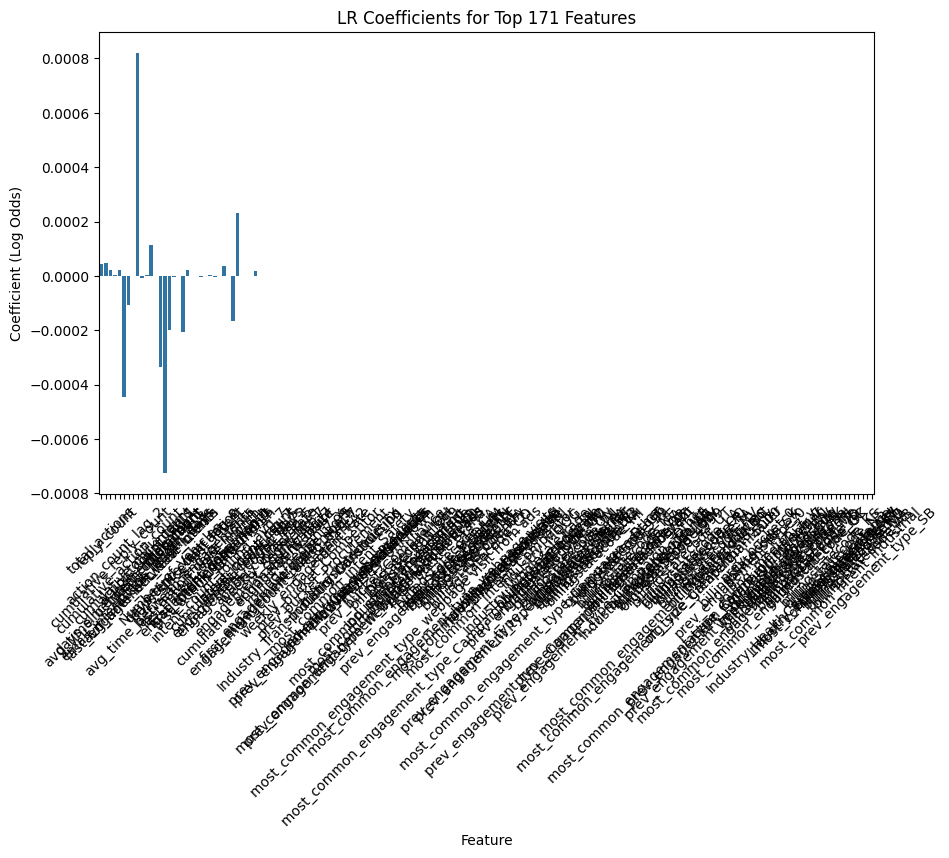

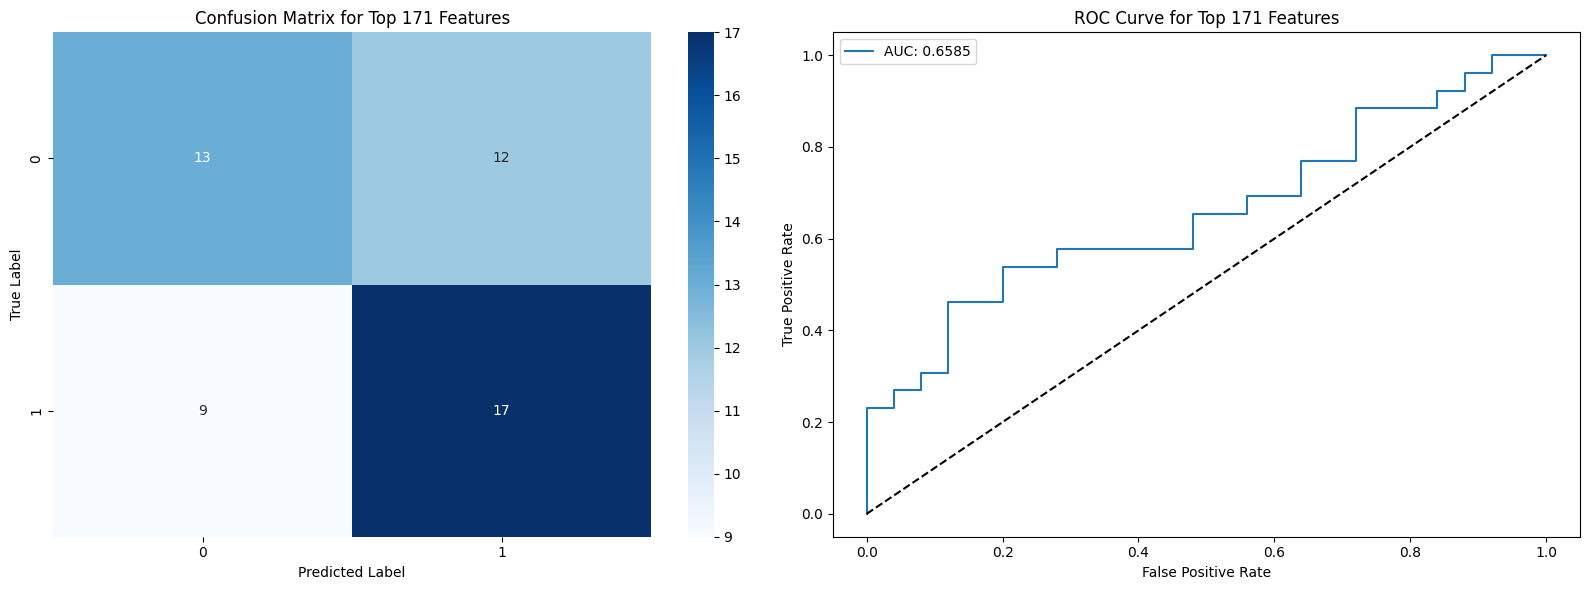

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score

# Assuming X and y are already defined
# If X and y are not defined, you need to load and preprocess your data accordingly

# Function to streamline the process for the entire dataset
def model_for_entire_dataset(X, y, num_features, threshold=0.5):
    results = {}
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train RandomForestClassifier
    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    
    # Calculate AUC score on validation set
    rf_auc_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    
    # Get feature importances
    feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    # Initialize lists
    base_clf_list = []
    train_auc_list = []
    test_auc_list = []
    confusion_matrices = []
    precisions = []
    recalls = []
    f1_scores = []
    roc_curves = []
    
    for i in range(num_features):  # Limiting to the first num_features most important features
        feature_names = list(feature_importances_sorted.index[:i+1])
        
        base_clf = LogisticRegression(random_state=0, solver='newton-cg', penalty='l2', C=1.0)
        base_clf.fit(X_train[feature_names], y_train)
        
        # Calculate AUC scores
        train_auc = roc_auc_score(y_train, base_clf.predict_proba(X_train[feature_names])[:, 1])
        val_auc = roc_auc_score(y_val, base_clf.predict_proba(X_val[feature_names])[:, 1])
        
        base_clf_list.append(base_clf)
        train_auc_list.append(train_auc)
        test_auc_list.append(val_auc)

        # Calculate predictions with custom threshold
        y_val_proba = base_clf.predict_proba(X_val[feature_names])[:, 1]
        y_val_pred = (y_val_proba >= threshold).astype(int)
        
        # Calculate confusion matrix, precision, recall, and f1 score
        cm = confusion_matrix(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)
        
        confusion_matrices.append(cm)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        roc_curves.append((fpr, tpr))
    
    # Print coefficient interpretations
    print(f"Interpreting coefficients for model with top {num_features} features:")
    coef = base_clf_list[-1].coef_[0]
    for j, feature in enumerate(feature_names):
        log_odds = coef[j]
        odds = np.exp(log_odds)
        probability = odds / (1 + odds)
        print(f"Feature: {feature}")
        print(f"  Log Odds: {log_odds:.4f}")
        print(f"  Odds: {odds:.4f}")
        print(f"  Probability: {probability*100:.2f}%")
        print(f"  Interpretation: For a one-unit increase in {feature}, the odds of the positive outcome {'increase' if log_odds > 0 else 'decrease'} by {odds:.4f} times (or by {(odds-1)*100:.2f}%). This corresponds to an increase in the probability to {probability*100:.2f}%.")

    # Store results
    results['feature_importances_sorted'] = feature_importances_sorted
    results['base_clf_list'] = base_clf_list
    results['train_auc_list'] = train_auc_list
    results['test_auc_list'] = test_auc_list
    results['rf_auc_val'] = rf_auc_val
    results['confusion_matrices'] = confusion_matrices
    results['precisions'] = precisions
    results['recalls'] = recalls
    results['f1_scores'] = f1_scores
    results['roc_curves'] = roc_curves
    
    return results

def plot_results(X, y, num_features, threshold=0.5):
    # Train models and get results
    results = model_for_entire_dataset(X, y, num_features, threshold)
    
    # Plotting the results using Seaborn
    def plot_auc_scores(results, num_features):
        x_axis = list(range(1, num_features+1))
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=x_axis, y=results['train_auc_list'], marker='o', label='Train AUC')
        sns.lineplot(x=x_axis, y=results['test_auc_list'], marker='o', label='Test AUC')
        plt.axhline(y=results['rf_auc_val'], color='r', linestyle='--', label='RF AUC')
        plt.title(f'AUC Scores for Top {num_features} Features')
        plt.xlabel('Number of Variables')
        plt.ylabel('AUC')
        plt.legend()
        plt.show()

    def plot_lr_coefficients(results, num_features):
        coef = results['base_clf_list'][num_features-1].coef_[0]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(results['feature_importances_sorted'].index[:num_features]), y=coef)
        plt.title(f'LR Coefficients for Top {num_features} Features')
        plt.xlabel('Feature')
        plt.ylabel('Coefficient (Log Odds)')
        plt.xticks(rotation=45)
        plt.show()

    plot_auc_scores(results, num_features)
    plot_lr_coefficients(results, num_features)

    # Plotting confusion matrix and ROC curve using matplotlib and seaborn
    def plot_confusion_matrix_and_roc(results):
        cm = results['confusion_matrices'][num_features-1]
        fpr, tpr = results['roc_curves'][num_features-1]
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        sns.heatmap(cm, annot=True, fmt="d", ax=axes[0], cmap="Blues")
        axes[0].set_title(f'Confusion Matrix for Top {num_features} Features')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('True Label')
        
        axes[1].plot(fpr, tpr, label=f'AUC: {results["test_auc_list"][num_features-1]:.4f}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title(f'ROC Curve for Top {num_features} Features')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='best')
        
        plt.tight_layout()
        plt.show()
    
    plot_confusion_matrix_and_roc(results)

# Example usage
plot_results(X_train, y_train, 4 , threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, 6, threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, 10, threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, 15, threshold=0.4)  # Adjust threshold to reduce false negatives
plot_results(X_train, y_train, len(X_train.columns), threshold=0.45)  # Adjust threshold to reduce false negatives

#### Prediction on Test

Interpreting coefficients for model with top 4 features:
Feature: total_actions
  Log Odds: -0.0575
  Odds: 0.9441
  Probability: 48.56%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9441 times (or by -5.59%). This corresponds to an increase in the probability to 48.56%.
Feature: reply_count
  Log Odds: 0.1162
  Odds: 1.1232
  Probability: 52.90%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1232 times (or by 12.32%). This corresponds to an increase in the probability to 52.90%.
Feature: cumulative_reply_count
  Log Odds: 0.1503
  Odds: 1.1622
  Probability: 53.75%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.1622 times (or by 16.22%). This corresponds to an increase in the probability to 53.75%.
Feature: action_count_lag_2
  Log Odds: 1.1459
  Odds: 3.1452
  Probability: 75.88%
  Interpretation: F

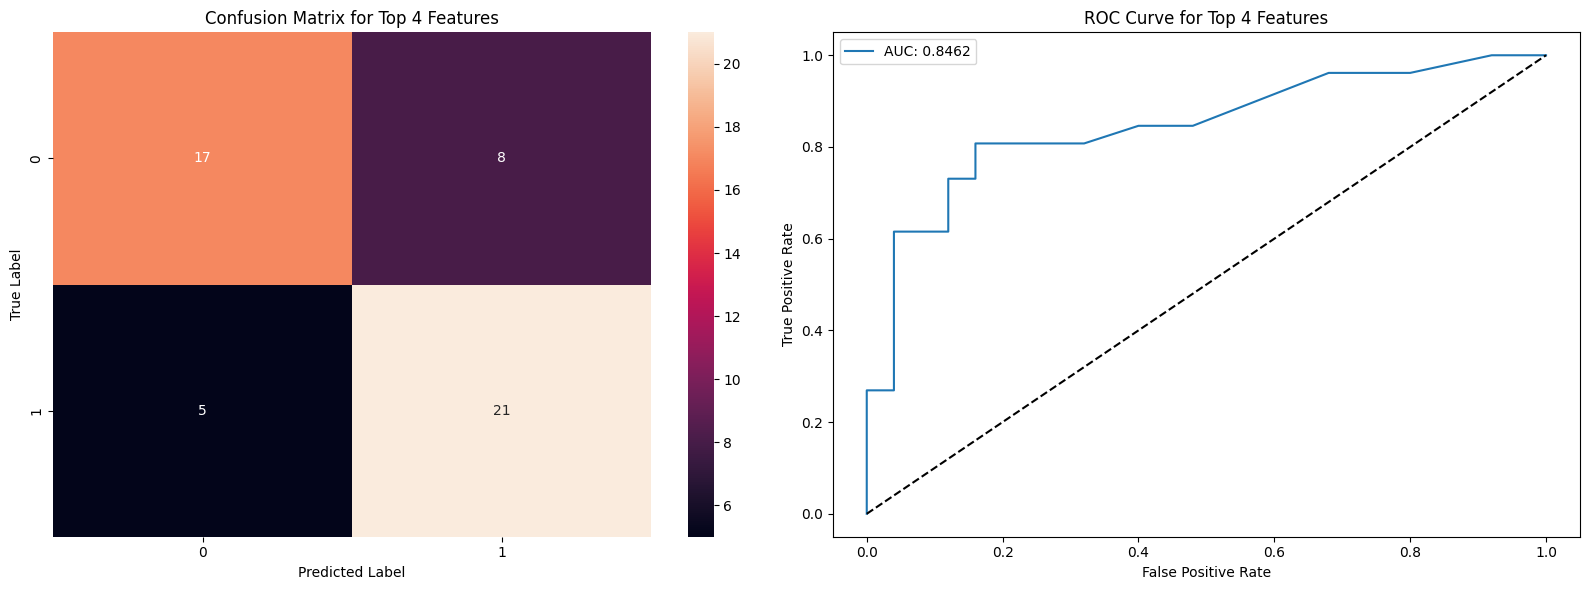

Interpreting coefficients for model with top 10 features:
Feature: total_actions
  Log Odds: -0.0120
  Odds: 0.9881
  Probability: 49.70%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome decrease by 0.9881 times (or by -1.19%). This corresponds to an increase in the probability to 49.70%.
Feature: reply_count
  Log Odds: 0.1106
  Odds: 1.1169
  Probability: 52.76%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.1169 times (or by 11.69%). This corresponds to an increase in the probability to 52.76%.
Feature: cumulative_reply_count
  Log Odds: 0.0864
  Odds: 1.0902
  Probability: 52.16%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.0902 times (or by 9.02%). This corresponds to an increase in the probability to 52.16%.
Feature: action_count_lag_2
  Log Odds: 1.1102
  Odds: 3.0349
  Probability: 75.22%
  Interpretation: F

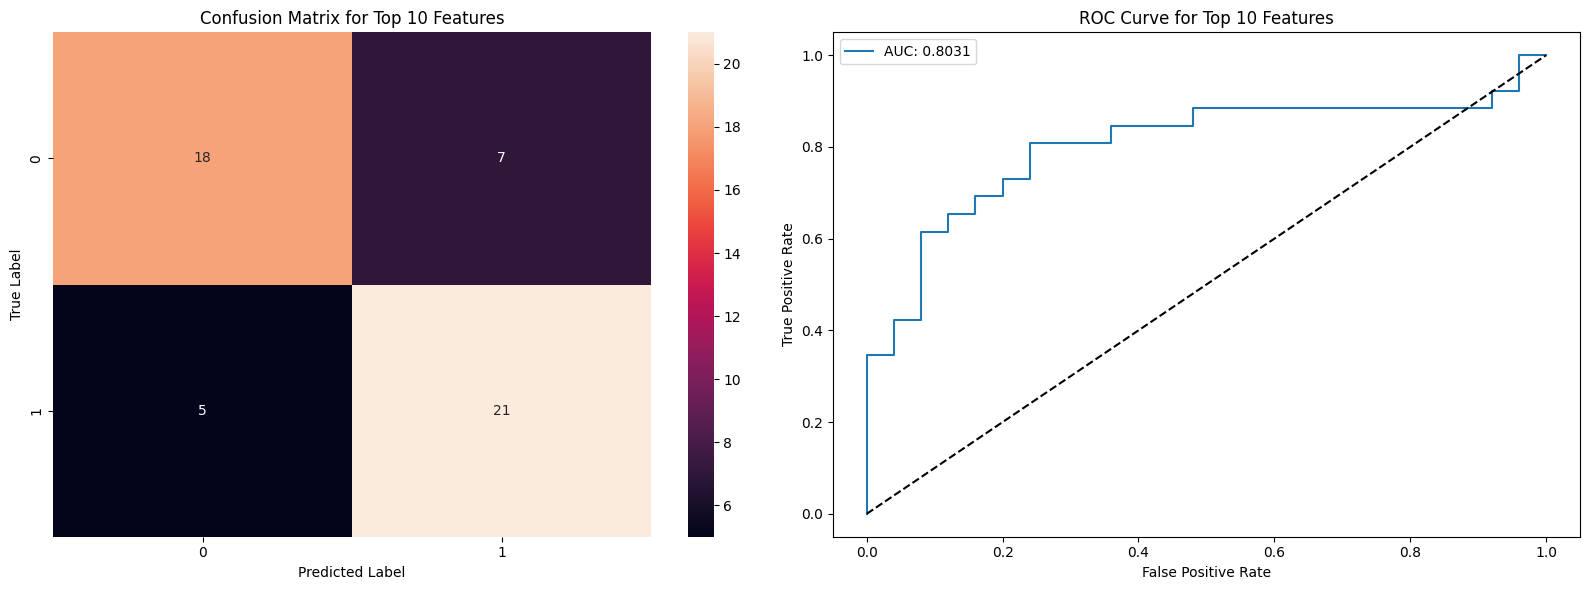

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311

Interpreting coefficients for model with top 171 features:
Feature: total_actions
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in total_actions, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: reply_count
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in reply_count, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: cumulative_reply_count
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For a one-unit increase in cumulative_reply_count, the odds of the positive outcome increase by 1.0000 times (or by 0.00%). This corresponds to an increase in the probability to 50.00%.
Feature: action_count_lag_2
  Log Odds: 0.0000
  Odds: 1.0000
  Probability: 50.00%
  Interpretation: For

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Python311\Lib\site-packages\sklearn\utils\optimize.py:239: UserWarning:

Line Search failed



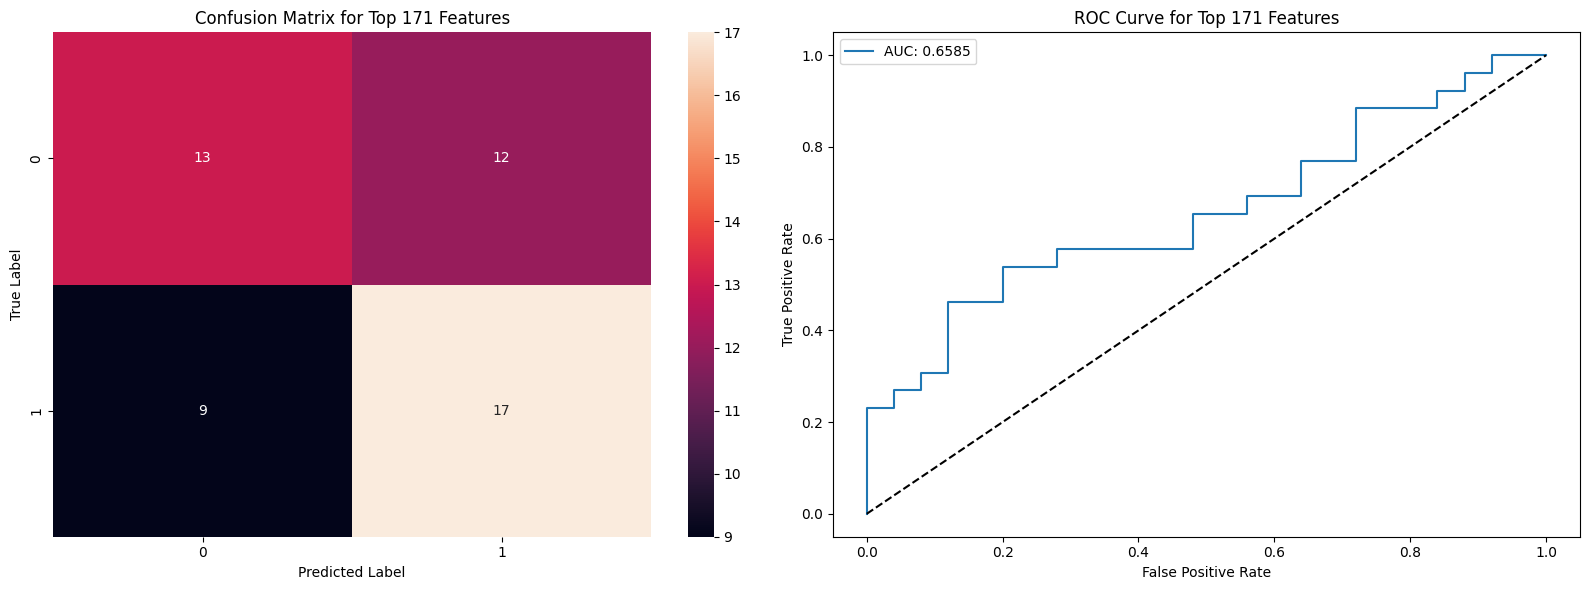

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score

# Assuming X and y are already defined
# If X and y are not defined, you need to load and preprocess your data accordingly

# Function to streamline the process for the entire dataset
def model_for_entire_dataset(X, y, num_features, threshold=0.5):
    results = {}
    
    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train RandomForestClassifier
    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    
    # Calculate AUC score on validation set
    rf_auc_val = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    
    # Get feature importances
    feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    
    # Initialize lists
    base_clf_list = []
    train_auc_list = []
    test_auc_list = []
    confusion_matrices = []
    precisions = []
    recalls = []
    f1_scores = []
    roc_curves = []
    
    for i in range(num_features):  # Limiting to the first num_features most important features
        feature_names = list(feature_importances_sorted.index[:i+1])
        
        base_clf = LogisticRegression(random_state=0, solver='newton-cg', penalty='l2', C=1.0)
        base_clf.fit(X_train[feature_names], y_train)
        
        # Calculate AUC scores
        train_auc = roc_auc_score(y_train, base_clf.predict_proba(X_train[feature_names])[:, 1])
        val_auc = roc_auc_score(y_val, base_clf.predict_proba(X_val[feature_names])[:, 1])
        
        base_clf_list.append(base_clf)
        train_auc_list.append(train_auc)
        test_auc_list.append(val_auc)

        # Calculate predictions with custom threshold
        y_val_proba = base_clf.predict_proba(X_val[feature_names])[:, 1]
        y_val_pred = (y_val_proba >= threshold).astype(int)
        
        # Calculate confusion matrix, precision, recall, and f1 score
        cm = confusion_matrix(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)
        
        confusion_matrices.append(cm)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_val_proba)
        roc_curves.append((fpr, tpr))
    
    # Print coefficient interpretations
    print(f"Interpreting coefficients for model with top {num_features} features:")
    coef = base_clf_list[-1].coef_[0]
    for j, feature in enumerate(feature_names):
        log_odds = coef[j]
        odds = np.exp(log_odds)
        probability = odds / (1 + odds)
        print(f"Feature: {feature}")
        print(f"  Log Odds: {log_odds:.4f}")
        print(f"  Odds: {odds:.4f}")
        print(f"  Probability: {probability*100:.2f}%")
        print(f"  Interpretation: For a one-unit increase in {feature}, the odds of the positive outcome {'increase' if log_odds > 0 else 'decrease'} by {odds:.4f} times (or by {(odds-1)*100:.2f}%). This corresponds to an increase in the probability to {probability*100:.2f}%.")

    # Store results
    results['feature_importances_sorted'] = feature_importances_sorted
    results['base_clf_list'] = base_clf_list
    results['train_auc_list'] = train_auc_list
    results['test_auc_list'] = test_auc_list
    results['rf_auc_val'] = rf_auc_val
    results['confusion_matrices'] = confusion_matrices
    results['precisions'] = precisions
    results['recalls'] = recalls
    results['f1_scores'] = f1_scores
    results['roc_curves'] = roc_curves
    results['final_model'] = base_clf_list[-1]
    results['selected_features'] = feature_names
    
    return results

def plot_results(X, y, num_features, threshold=0.5):
    # Train models and get results
    results = model_for_entire_dataset(X, y, num_features, threshold)
    
    # Plotting the results using Plotly
    def plot_auc_scores(results, num_features):
        x_axis = list(range(1, num_features+1))
        fig_auc = go.Figure()

        fig_auc.add_trace(go.Scatter(x=x_axis, y=results['train_auc_list'], mode='lines+markers', name='Train AUC'))
        fig_auc.add_trace(go.Scatter(x=x_axis, y=results['test_auc_list'], mode='lines+markers', name='Test AUC'))
        fig_auc.add_trace(go.Scatter(x=x_axis, y=[results['rf_auc_val']] * num_features, mode='lines', name='RF AUC', line=dict(dash='dash')))

        fig_auc.update_layout(
            title=f'AUC Scores for Top {num_features} Features',
            xaxis_title='Number of Variables',
            yaxis_title='AUC',
            legend_title='Legend'
        )
        return fig_auc

    def plot_lr_coefficients(results, num_features):
        coef = results['base_clf_list'][num_features-1].coef_[0]
        fig_coef = go.Figure()
        fig_coef.add_trace(go.Bar(x=list(results['feature_importances_sorted'].index[:num_features]), y=coef))

        fig_coef.update_layout(
            title=f'LR Coefficients for Top {num_features} Features',
            xaxis_title='Feature',
            yaxis_title='Coefficient (Log Odds)',
            xaxis_tickangle=45
        )
        return fig_coef

    fig_auc = plot_auc_scores(results, num_features)
    fig_coef = plot_lr_coefficients(results, num_features)
    
    fig_auc.show()
    fig_coef.show()

    # Plotting confusion matrix and ROC curve using matplotlib and seaborn
    def plot_confusion_matrix_and_roc(results):
        cm = results['confusion_matrices'][num_features-1]
        fpr, tpr = results['roc_curves'][num_features-1]
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        sns.heatmap(cm, annot=True, fmt="d", ax=axes[0])
        axes[0].set_title(f'Confusion Matrix for Top {num_features} Features')
        axes[0].set_xlabel('Predicted Label')
        axes[0].set_ylabel('True Label')
        
        axes[1].plot(fpr, tpr, label=f'AUC: {results["test_auc_list"][num_features-1]:.4f}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title(f'ROC Curve for Top {num_features} Features')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].legend(loc='best')
        
        plt.tight_layout()
        plt.show()
    
    plot_confusion_matrix_and_roc(results)
    return results['final_model'], results['selected_features']

# Example usage
model_4, features_4 = plot_results(X_train, y_train, 4 , threshold=0.4)  # Adjust threshold to reduce false negatives
model_10, features_10 = plot_results(X_train, y_train, 10, threshold=0.4)  # Adjust threshold to reduce false negatives
model_all, features_all = plot_results(X_train, y_train, len(X_train.columns), threshold=0.45)  # Adjust threshold to reduce false negatives



##### Prediction
**Prediction with model with 4 features on test dataset**

In [157]:
from collections import Counter

# Example prediction on unseen test data for model 4
# Assuming X_test and features_4 are already defined
y_test_proba_4 = model_4.predict_proba(test[features_4])[:, 1]
y_test_pred_4 = (y_test_proba_4 >= 0.4).astype(int)
final_test_predictions_4 = pd.DataFrame({
    'Predicted_Proba_4': y_test_proba_4,
    'Predicted_Label_4': y_test_pred_4
}, index=test.index)

print(final_test_predictions_4)


           Predicted_Proba_4  Predicted_Label_4
id_number                                      
1300                0.262557                  0
1403                0.273840                  0
2226                0.067851                  0
2796                0.607900                  1
2797                0.452132                  1
...                      ...                ...
2610                0.224134                  0
2732                0.262557                  0
2773                0.273933                  0
2944                0.810326                  1
3006                0.379458                  0

[132 rows x 2 columns]


In [158]:
import pandas as pd

# Merge the predictions with the original test data for model 4
detailed_test_predictions_4 = test.copy()
detailed_test_predictions_4['Predicted_Proba_4'] = final_test_predictions_4['Predicted_Proba_4']
detailed_test_predictions_4['Predicted_Label_4'] = final_test_predictions_4['Predicted_Label_4']

# Filter and sort by the predicted probability for model 4
most_likely_to_convert_4 = detailed_test_predictions_4[detailed_test_predictions_4['Predicted_Label_4'] == 1].sort_values(by='Predicted_Proba_4', ascending=False)


In [159]:
most_likely_to_convert_4.head()

,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Has_Website,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,...,most_common_intent_Telematics,D&B_Score,first_engagement_date_month,last_engagement_date_month,first_action_date_month,last_action_date_month,first_intent_date_month,last_intent_date_month,Predicted_Proba_4,Predicted_Label_4
id_number,,,,,,,,,,,,,,,,,,,,,
1158,0,0,0,0,1,1,130.0,0,0,0,...,0,HIGH,4,12,3,1,2,3,0.864448,1
2944,1,0,0,0,0,1,120.0,0,0,0,...,0,HIGH,5,7,5,11,3,1,0.810326,1
2464,1,0,0,0,0,1,185.0,0,1,0,...,1,HIGH,4,10,6,1,2,2,0.797857,1
2868,1,0,0,0,0,1,28.0,0,0,1,...,0,HIGH,6,3,12,2,12,10,0.789253,1
1361,0,1,0,0,0,1,72.0,0,0,0,...,0,HIGH,5,8,7,7,3,4,0.784024,1


In [160]:
most_likely_to_convert_4.shape

(40, 106)

**Prediction with model with 10 features on test dataset**

In [161]:
# Example prediction on unseen test data for model 10
# Assuming X_test and features_10 are already defined
y_test_proba_10 = model_10.predict_proba(test[features_10])[:, 1]
y_test_pred_10 = (y_test_proba_10 >= 0.4).astype(int)
final_test_predictions_10 = pd.DataFrame({
    'Predicted_Proba_10': y_test_proba_10,
    'Predicted_Label_10': y_test_pred_10
}, index=test.index)

# Merge the predictions with the original test data for model 10
detailed_test_predictions_10 = test.copy()
detailed_test_predictions_10['Predicted_Proba_10'] = final_test_predictions_10['Predicted_Proba_10']
detailed_test_predictions_10['Predicted_Label_10'] = final_test_predictions_10['Predicted_Label_10']

# Filter and sort by the predicted probability for model 10
most_likely_to_convert_10 = detailed_test_predictions_10[detailed_test_predictions_10['Predicted_Label_10'] == 1].sort_values(by='Predicted_Proba_10', ascending=False)


In [162]:
most_likely_to_convert_10.shape

(35, 106)

**Companies that have been predicted to lead to a sale from both models**

In [163]:
# Merge the predictions with the original test data for model 4
detailed_test_predictions_4 = test.copy()
detailed_test_predictions_4['Predicted_Proba_4'] = final_test_predictions_4['Predicted_Proba_4']
detailed_test_predictions_4['Predicted_Label_4'] = final_test_predictions_4['Predicted_Label_4']

# Filter and sort by the predicted probability for model 4
most_likely_to_convert_4 = detailed_test_predictions_4[detailed_test_predictions_4['Predicted_Label_4'] == 1].sort_values(by='Predicted_Proba_4', ascending=False)

# Count the occurrences of indexes in each list
counter1 = Counter(most_likely_to_convert_10.index)
counter2 = Counter(most_likely_to_convert_4.index)

# Find the common indexes
common_indexes = [element for element in counter1 if element in counter2]

print("Common Indexes:", common_indexes)

# Filter the test data to show details of the companies with common indexes
common_details = test.loc[common_indexes]

# Add columns for predicted probabilities from both models
common_details['Predicted_Proba_10'] = final_test_predictions_10.loc[common_indexes, 'Predicted_Proba_10']
common_details['Predicted_Proba_4'] = final_test_predictions_4.loc[common_indexes, 'Predicted_Proba_4']

# Display the details sorted by the higher of the two probabilities
common_details['Max_Proba'] = common_details[['Predicted_Proba_10', 'Predicted_Proba_4']].max(axis=1)
common_details_sorted = common_details.sort_values(by='Max_Proba', ascending=False)

common_details_sorted.head()

Common Indexes: [1369, 2868, 1158, 2944, 2822, 2464, 1361, 506, 2772, 2796, 1567, 2792, 2347, 1042, 775, 1410, 945, 1086, 767, 1670, 911, 1006, 2797, 2483, 402, 2917, 1882, 2191, 1370, 3005]


,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Has_Website,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,...,D&B_Score,first_engagement_date_month,last_engagement_date_month,first_action_date_month,last_action_date_month,first_intent_date_month,last_intent_date_month,Predicted_Proba_10,Predicted_Proba_4,Max_Proba
id_number,,,,,,,,,,,,,,,,,,,,,
1158,0,0,0,0,1,1,130.0,0,0,0,...,HIGH,4,12,3,1,2,3,0.778099,0.864448,0.864448
1369,0,1,0,0,0,1,10000.0,1,0,0,...,HIGH,5,2,5,6,2,2,0.832385,0.765538,0.832385
2868,1,0,0,0,0,1,28.0,0,0,1,...,HIGH,6,3,12,2,12,10,0.828805,0.789253,0.828805
2944,1,0,0,0,0,1,120.0,0,0,0,...,HIGH,5,7,5,11,3,1,0.754701,0.810326,0.810326
2464,1,0,0,0,0,1,185.0,0,1,0,...,HIGH,4,10,6,1,2,2,0.720021,0.797857,0.797857


#### **Yield estimate** of the potential sales

Based on this website [here](https://tech.co/fleet-management/samsara-vs-motive#:~:text=We've%20found%20that%20a,%2425%20per%20vehicle%20per%20month.) the price per vehicle seems to be between 27 and 33 dollars USD per month, so I will use $30 dollars per month, for 1 year as estimate.

In [164]:
from collections import Counter
import pandas as pd



# Create a new column 'Annual_Potential_Yield' based on the number of vehicles
common_details_sorted['Annual_Potential_Yield'] = common_details_sorted['Number_of_Vehicles__c'] * 30 * 12

# Display the resulting DataFrame
common_details_sorted
potential_accounts = common_details_sorted
print(potential_accounts.shape)
potential_accounts.head()

(30, 108)


,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Has_Website,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,...,first_engagement_date_month,last_engagement_date_month,first_action_date_month,last_action_date_month,first_intent_date_month,last_intent_date_month,Predicted_Proba_10,Predicted_Proba_4,Max_Proba,Annual_Potential_Yield
id_number,,,,,,,,,,,,,,,,,,,,,
1158,0,0,0,0,1,1,130.0,0,0,0,...,4,12,3,1,2,3,0.778099,0.864448,0.864448,46800.0
1369,0,1,0,0,0,1,10000.0,1,0,0,...,5,2,5,6,2,2,0.832385,0.765538,0.832385,3600000.0
2868,1,0,0,0,0,1,28.0,0,0,1,...,6,3,12,2,12,10,0.828805,0.789253,0.828805,10080.0
2944,1,0,0,0,0,1,120.0,0,0,0,...,5,7,5,11,3,1,0.754701,0.810326,0.810326,43200.0
2464,1,0,0,0,0,1,185.0,0,1,0,...,4,10,6,1,2,2,0.720021,0.797857,0.797857,66600.0


### Let's look at which companies have been considered highly likely to revert to a sale

In [165]:
potential_accounts_high = potential_accounts[potential_accounts['Max_Proba']>0.7]
potential_accounts_high.head()
potential_accounts_low = potential_accounts[potential_accounts['Max_Proba']<0.7]
potential_accounts_low.head()

,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Has_Website,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,...,first_engagement_date_month,last_engagement_date_month,first_action_date_month,last_action_date_month,first_intent_date_month,last_intent_date_month,Predicted_Proba_10,Predicted_Proba_4,Max_Proba,Annual_Potential_Yield
id_number,,,,,,,,,,,,,,,,,,,,,
2772,0,1,0,0,0,1,60.0,0,1,0,...,4,1,12,1,4,8,0.677301,0.612369,0.677301,21600.0
2796,0,0,0,1,0,1,158.0,1,0,0,...,4,3,5,1,4,3,0.672899,0.607900,0.672899,56880.0
1410,0,1,0,0,0,1,65.0,0,0,0,...,1,6,11,6,7,2,0.594731,0.636298,0.636298,23400.0
2347,1,0,0,0,0,1,150.0,0,0,0,...,5,5,5,10,12,3,0.628731,0.561620,0.628731,54000.0
1086,0,0,1,0,0,1,300.0,0,1,0,...,8,11,10,5,2,2,0.570528,0.624376,0.624376,108000.0


In [166]:
potential_accounts_high[['Annual_Potential_Yield', 'Predicted_Proba_10', 'Predicted_Proba_4', 'Max_Proba']].sort_values(by='Max_Proba', ascending=False)

,Annual_Potential_Yield,Predicted_Proba_10,Predicted_Proba_4,Max_Proba
id_number,,,,
1158,46800.0,0.778099,0.864448,0.864448
1369,3600000.0,0.832385,0.765538,0.832385
2868,10080.0,0.828805,0.789253,0.828805
2944,43200.0,0.754701,0.810326,0.810326
2464,66600.0,0.720021,0.797857,0.797857
1361,25920.0,0.719157,0.784024,0.784024
506,32400.0,0.691803,0.759803,0.759803
1567,5400.0,0.656276,0.754359,0.754359
2822,27360.0,0.748654,0.728473,0.748654


In [167]:
potential_accounts_high[['Annual_Potential_Yield', 'Predicted_Proba_10', 'Predicted_Proba_4', 'Max_Proba']].sort_values(by='Max_Proba', ascending=False)['Annual_Potential_Yield'].sum()

3877560.0

In [168]:
potential_accounts_low[['Annual_Potential_Yield', 'Predicted_Proba_10', 'Predicted_Proba_4', 'Max_Proba']].sort_values(by='Max_Proba', ascending=False)

,Annual_Potential_Yield,Predicted_Proba_10,Predicted_Proba_4,Max_Proba
id_number,,,,
2772,21600.0,0.677301,0.612369,0.677301
2796,56880.0,0.672899,0.607900,0.672899
1410,23400.0,0.594731,0.636298,0.636298
2347,54000.0,0.628731,0.561620,0.628731
1086,108000.0,0.570528,0.624376,0.624376
1042,7200.0,0.621915,0.547726,0.621915
767,7200.0,0.557432,0.612538,0.612538
775,7920.0,0.607234,0.477261,0.607234
945,9000.0,0.576478,0.528874,0.576478


In [169]:
potential_accounts_low[['Annual_Potential_Yield', 'Predicted_Proba_10', 'Predicted_Proba_4', 'Max_Proba']].sort_values(by='Max_Proba', ascending=False)['Annual_Potential_Yield'].sum()

1605600.0

In [170]:
potential_accounts_high.shape

(10, 108)

In [171]:
potential_accounts.head()

,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Has_Website,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,...,first_engagement_date_month,last_engagement_date_month,first_action_date_month,last_action_date_month,first_intent_date_month,last_intent_date_month,Predicted_Proba_10,Predicted_Proba_4,Max_Proba,Annual_Potential_Yield
id_number,,,,,,,,,,,,,,,,,,,,,
1158,0,0,0,0,1,1,130.0,0,0,0,...,4,12,3,1,2,3,0.778099,0.864448,0.864448,46800.0
1369,0,1,0,0,0,1,10000.0,1,0,0,...,5,2,5,6,2,2,0.832385,0.765538,0.832385,3600000.0
2868,1,0,0,0,0,1,28.0,0,0,1,...,6,3,12,2,12,10,0.828805,0.789253,0.828805,10080.0
2944,1,0,0,0,0,1,120.0,0,0,0,...,5,7,5,11,3,1,0.754701,0.810326,0.810326,43200.0
2464,1,0,0,0,0,1,185.0,0,1,0,...,4,10,6,1,2,2,0.720021,0.797857,0.797857,66600.0


In [172]:
potential_accounts_low.shape

(20, 108)

In [173]:
import pandas as pd
import plotly.graph_objects as go

# Assuming potential_accounts_high and potential_accounts_low are already loaded as DataFrames

# Define the size categories
size_ = ['org_size_1_99', 'org_size_500_999', 'org_size_1000_4999', 'org_size_greaterthan_5000']

def calculate_percentages(df):
    percentages = []
    labels = []
    total_companies = len(df.index.unique())
    
    for s in size_:
        perc_ = (df[s].sum() / total_companies) * 100
        percentages.append(perc_)
        labels.append(s)
        print(f"{perc_:.2f}%: of the accounts are classified as {s}.")
        print("")
    
    # Calculate the percentage for the remaining category
    remaining_percentage = 100 - sum(percentages)
    percentages.append(remaining_percentage)
    labels.append('org_size_100_499')
    print(f"{remaining_percentage:.2f}% of the accounts is classified as org_size_100_499")
    
    return labels, percentages

# Calculate percentages for both datasets
labels_high, percentages_high = calculate_percentages(potential_accounts_high)
labels_low, percentages_low = calculate_percentages(potential_accounts_low)

# Create pie charts
fig = go.Figure()

# Pie chart for potential_accounts_high
fig.add_trace(go.Pie(
    labels=labels_high, 
    values=percentages_high, 
    textinfo='label+percent', 
    name='High Potential Accounts',
    domain=dict(x=[0, 0.4])  # Adjusting the position
))

# Pie chart for potential_accounts_low
fig.add_trace(go.Pie(
    labels=labels_low, 
    values=percentages_low, 
    textinfo='label+percent', 
    name='Low Potential Accounts',
    domain=dict(x=[0.6, 1.0])  # Adjusting the position
))

# Update layout to place pie charts side by side with more spacing
fig.update_layout(
    title_text="Distribution of Accounts by Organization Size",
    annotations=[
        dict(text='High Potential Accounts', x=0.1, y=1.1, font_size=18, showarrow=False),
        dict(text='Low Potential Accounts', x=0.9, y=1.1, font_size=18, showarrow=False)
    ]
)

# Show the plot
fig.write_html("distribution_of_accounts_by_org_size.html")

fig.show()


60.00%: of the accounts are classified as org_size_1_99.

0.00%: of the accounts are classified as org_size_500_999.

0.00%: of the accounts are classified as org_size_1000_4999.

10.00%: of the accounts are classified as org_size_greaterthan_5000.

30.00% of the accounts is classified as org_size_100_499
55.00%: of the accounts are classified as org_size_1_99.

5.00%: of the accounts are classified as org_size_500_999.

5.00%: of the accounts are classified as org_size_1000_4999.

5.00%: of the accounts are classified as org_size_greaterthan_5000.

30.00% of the accounts is classified as org_size_100_499


#### Transforming one hot encoded variables back to a column for visualization purposes

#### Putting back the one hot encoded variables to a single column for visualization purposes

In [174]:

# import numpy as np
# import pandas as pd

# def convert_one_hot_to_categorical(df, prefix):
#     """
#     Convert one-hot encoded columns with a given prefix back to a single categorical column.
    
#     Parameters:
#         df (pd.DataFrame): The dataframe containing the one-hot encoded columns.
#         prefix (str): The prefix of the one-hot encoded columns.
    
#     Returns:
#         pd.DataFrame: The dataframe with the one-hot encoded columns replaced by a single categorical column.
#     """
#     # Identify the one-hot encoded columns
#     one_hot_columns = [col for col in df.columns if col.startswith(prefix)]
    
#     # Function to extract the category from one-hot encoding
#     def get_category(row):
#         for col in one_hot_columns:
#             if row[col] == 1:
#                 return col.split('_', 1)[1]  # Ensure we split on the first underscore only
#         return np.nan

#     # Apply the function to create the categorical column
#     df[prefix[:-1]] = df.apply(get_category, axis=1)
    
#     # Drop the old one-hot encoded columns
#     df = df.drop(columns=one_hot_columns)
    
#     return df

# # Assuming potential_accounts is already loaded as a DataFrame

# # Convert 'billingstatecode_' one-hot encoded columns
# potential_accounts = convert_one_hot_to_categorical(potential_accounts, 'billingstatecode_')

# # Display the updated DataFrame
# print(potential_accounts[['billingstatecode'] + [col for col in potential_accounts.columns if col.startswith('billingstatecode_')]])

# # Convert 'Industry_' one-hot encoded columns
# potential_accounts = convert_one_hot_to_categorical(potential_accounts, 'Industry_')

# # Display the updated DataFrame
# print(potential_accounts[['Industry'] + [col for col in potential_accounts.columns if col.startswith('Industry_')]])

# # Display the first few rows of the updated DataFrame
# print(potential_accounts.head())


In [175]:
potential_accounts['billingstatecode']

id_number
1158    GA
1369    IN
2868    VA
2944    WA
2464    PA
1361    IN
506     AZ
1567    MD
2822    UT
2792    TX
2772    TX
2796    TX
1410    KS
2347    ON
1086    FL
1042    FL
767     CA
775     CA
945     DC
911     CO
2917    WA
1670    MI
1006    FL
2797    TX
2483    QC
402     AR
1882    NC
2191    OH
3005    WI
1370    IN
Name: billingstatecode, dtype: object

In [176]:
potential_accounts_high = potential_accounts[potential_accounts['Max_Proba']>0.7]
potential_accounts_high.head()
potential_accounts_low = potential_accounts[potential_accounts['Max_Proba']<0.7]
potential_accounts_low.head()

,org_size_1_99,org_size_100_499,org_size_500_999,org_size_1000_4999,org_size_greaterthan_5000,Has_Website,Number_of_Vehicles__c,Segment_E,SegmentE3,SegmentA1,...,first_engagement_date_month,last_engagement_date_month,first_action_date_month,last_action_date_month,first_intent_date_month,last_intent_date_month,Predicted_Proba_10,Predicted_Proba_4,Max_Proba,Annual_Potential_Yield
id_number,,,,,,,,,,,,,,,,,,,,,
2772,0,1,0,0,0,1,60.0,0,1,0,...,4,1,12,1,4,8,0.677301,0.612369,0.677301,21600.0
2796,0,0,0,1,0,1,158.0,1,0,0,...,4,3,5,1,4,3,0.672899,0.607900,0.672899,56880.0
1410,0,1,0,0,0,1,65.0,0,0,0,...,1,6,11,6,7,2,0.594731,0.636298,0.636298,23400.0
2347,1,0,0,0,0,1,150.0,0,0,0,...,5,5,5,10,12,3,0.628731,0.561620,0.628731,54000.0
1086,0,0,1,0,0,1,300.0,0,1,0,...,8,11,10,5,2,2,0.570528,0.624376,0.624376,108000.0


#### Visualizations

In [178]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

# Set Plotly credentials
chart_studio.tools.set_credentials_file(username='thevitorialima', api_key='Z0P9d5apmfWIA3UYmS5G')

# Function to generate the plots for a given organization size
def generate_plots_for_size(size_column, potential_accounts):
    # Filter data for the given size
    size_data = potential_accounts[potential_accounts[size_column] == 1]

    # Plot the heatmap on US map
    state_data = size_data['billingstatecode'].value_counts().reset_index()
    state_data.columns = ['State', 'Count']

    # Plot number of accounts in each industry
    industry_data = size_data['Industry'].value_counts().reset_index()
    industry_data.columns = ['Industry', 'Count']

    # Check for negative or invalid values in the 'Number_of_Vehicles__c' column
    size_data = size_data[size_data['Number_of_Vehicles__c'] >= 0]

    # Manually define the bin edges
    bins = [0, 10, 50, 100, 500, 1000, 5000, 10000]
    labels = ['0-10', '11-50', '51-100', '101-500', '501-1000', '1001-5000', '5001-10000']

    # Create bins for the number of vehicles
    size_data['Vehicle_Range'] = pd.cut(size_data['Number_of_Vehicles__c'], bins=bins, labels=labels, right=False)
    vehicle_data = size_data['Vehicle_Range'].value_counts().reset_index()
    vehicle_data.columns = ['Vehicle_Range', 'Count']

    # Calculate the potential annual yield
    size_data['Annual_Potential_Yield'] = size_data['Number_of_Vehicles__c'] * 30 * 12
    yield_data = size_data.groupby('Vehicle_Range')['Annual_Potential_Yield'].sum().reset_index()
    yield_data.columns = ['Vehicle_Range', 'Annual_Potential_Yield']

    # Determine the largest bubble size
    max_count = vehicle_data['Count'].max()
    max_yield = yield_data['Annual_Potential_Yield'].max()

    # Create text for the bubbles
    bubble_text = [
        f'{count} companies have<br>{label} Vehicles' if count == max_count else f'{count}'
        for count, label in zip(vehicle_data['Count'], vehicle_data['Vehicle_Range'])
    ]

    yield_text = [
        f'${yield_value:,.0f} Annual Yield<br>{label} Vehicles' if yield_value == max_yield else f'${yield_value:,.0f}'
        for yield_value, label in zip(yield_data['Annual_Potential_Yield'], yield_data['Vehicle_Range'])
    ]

    # Set text positions
    text_positions = [
        'bottom center' if count == max_count and label == '11-50' else 'middle right'
        for count, label in zip(vehicle_data['Count'], vehicle_data['Vehicle_Range'])
    ]

    yield_text_positions = [
        'middle left' if yield_value == max_yield else 'middle right'
        for yield_value in yield_data['Annual_Potential_Yield']
    ]

    # Create subplots
    fig = make_subplots(
        rows=1, cols=4,
        subplot_titles=(
            "Accounts by Industry",
            "Amount of Companies Owning Vehicles - Per Range of Vehicles",
            "Annual Potential Yield by Vehicle Range",
            "Number of Accounts by State"
        ),
        column_widths=[0.25, 0.25, 0.25, 0.25],
        horizontal_spacing=0.05,  # Reduced horizontal spacing
        specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}, {"type": "choropleth"}]]
    )

    # Add the bar plot to the subplot
    fig.add_trace(
        go.Bar(
            x=industry_data['Count'],
            y=industry_data['Industry'],
            orientation='h'
        ),
        row=1, col=1
    )

    # Add the first bubble plot to the subplot
    fig.add_trace(
        go.Scatter(
            x=vehicle_data['Vehicle_Range'],
            y=vehicle_data['Count'],
            mode='markers+text',
            text=bubble_text,
            textposition=text_positions,
            marker=dict(size=vehicle_data['Count'], sizemode='area', sizeref=2.*max_count/(60.**2), sizemin=4),
            textfont=dict(size=14)  # Increased font size
        ),
        row=1, col=2
    )

    # Add the second bubble plot to the subplot
    fig.add_trace(
        go.Scatter(
            x=yield_data['Vehicle_Range'],
            y=yield_data['Annual_Potential_Yield'],
            mode='markers+text',
            text=yield_text,
            textposition=yield_text_positions,
            marker=dict(size=yield_data['Annual_Potential_Yield'], sizemode='area', sizeref=2.*max_yield/(60.**2), sizemin=4),
            textfont=dict(size=14)  # Increased font size
        ),
        row=1, col=3
    )

    # Add the choropleth map to the subplot
    fig.add_trace(
        go.Choropleth(
            locations=state_data['State'],
            z=state_data['Count'],
            locationmode='USA-states',
            colorscale="Viridis",
            colorbar_title="Count"
        ),
        row=1, col=4
    )
    fig.update_geos(projection_scale=5, center=dict(lat=37.0902, lon=-95.7129), row=1, col=4)

    # Update layout
    fig.update_layout(
        title={
            'text': f"<b>Analysis of Accounts from {size_column}</b>",
            'y': 0.98,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font_size': 20
        },
        showlegend=False,
        height=600,  # Adjusted height
        width=2400,  # Adjusted width
        margin=dict(l=20, r=20, t=80, b=20)  # Reduced top margin
    )

    # Update subplot title font sizes
    fig.update_annotations(font_size=16)

    # Save the plot to your Plotly account
    py.plot(fig, filename=f'Analysis_of_Accounts_from_{size_column}', auto_open=False)

    # Show the plot locally
    fig.show()

# List of organization sizes to analyze
sizes = ['org_size_1_99', 'org_size_100_499', 'org_size_500_999', 'org_size_1000_4999', 'org_size_greaterthan_5000']




In [179]:
potential_accounts['Annual_Potential_Yield'].sum()

5483160.0

In [180]:
# Generate plots for each size
for size in sizes:
    generate_plots_for_size(size, potential_accounts)

C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [181]:
# Generate plots for each size
for size in sizes:
    generate_plots_for_size(size, potential_accounts_high)

C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [182]:
# Generate plots for each size
for size in sizes:
    generate_plots_for_size(size, potential_accounts_low)

C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Caleb\AppData\Local\Temp\ipykernel_35216\2990450884.py:39: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**End of Notebook**